<a href="https://colab.research.google.com/github/rentton/AdvenOfCode21-22/blob/master/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Configuration

In [ ]:
# Run the cell for connecting with GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SystemError: ignored

In [ ]:
# # Run the cell for connecting with TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/TFG

/content/gdrive/MyDrive/TFG


In [ ]:
%ls

In [ ]:
%pwd

################################################################################################################################################################################################################################################

# Reading Dataset

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.6f' % x)
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
%cd /content/gdrive/MyDrive/TFG

df_glucose = pd.read_csv("Preprocessed_data.csv", dtype={'Glucose_measurements' : int})

/content/gdrive/MyDrive/TFG


In [ ]:
df_glucose     # TODO: Fix the unnamed col

Unnamed: 0 Patient_ID  Measurement
0                  0  LIB193263    99.000000
1                  1  LIB193263    92.000000
2                  2  LIB193263    86.000000
3                  3  LIB193263    85.000000
4                  4  LIB193263    85.000000
...              ...        ...          ...
31074573    31341295  LIB194166   143.000000
31074574    31341296  LIB194166   169.000000
31074575    31341297  LIB194166   206.000000
31074576    31341298  LIB194166   215.000000
31074577    31341299  LIB194166   204.000000

[31074578 rows x 3 columns]

In [ ]:
df_glucose['Measurement'].isnull().sum()

8857816

## Dividing into Train-Validation-Test:
### 70% of patients for training, 20% for testing and 10% for validation

In [ ]:
def get_patient_ids(df):
    """

    :param df_glucose:
    :return: List of patient ids
    """
    return df['Patient_ID'].unique()

In [ ]:
patients = get_patient_ids(df=df_glucose)
patients_size = patients.shape[0]

patients_for_testing = int(patients_size * 0.2)
patients_for_validation = int(patients_size * 0.1)

In [ ]:
patients_size

In [ ]:
patients_for_testing

In [ ]:
patients_for_validation

In [ ]:
# Stratified train/validation/test datasets
# For each ten patients ordered by number of measurements: 7 for training, 2 for testing, 1 for validation

import random

remaining_patients = patients_size % 10

# Create a list to store the selected numbers
train_indexes =      []
test_indexes =       []
validation_indexes = []

# Iterate over the range of numbers from 0 to patients_size
for num in range(0, patients_size - remaining_patients, 10):
    # Generate a list of consecutive numbers in the group
    group = list(range(num, num+10))

    # Testing
    random_nums_testing = random.sample(group, 2)
    test_indexes.append(random_nums_testing[0])
    test_indexes.append(random_nums_testing[1])

    group.remove(random_nums_testing[0])
    group.remove(random_nums_testing[1])

    # Validation
    random_num_validation = random.choice(group)
    validation_indexes.append(random_num_validation)

    group.remove(random_num_validation)

    # Training
    train_indexes.extend(group)

# Remaining patients
remaining_patients_indexes = list(range(patients_size - remaining_patients, patients_size))
if remaining_patients < 7:
  train_indexes += remaining_patients_indexes
else:
  train_indexes += remaining_patients_indexes[:7]
  test_indexes += remaining_patients_indexes[7:]

In [ ]:
assert not set(train_indexes) & set(test_indexes) & set(validation_indexes)
assert len(test_indexes) == patients_for_testing and len(validation_indexes) == patients_for_validation
assert len(train_indexes) == patients_size - patients_for_testing - patients_for_validation

In [ ]:
amount_of_data_per_patient_not_null = df_glucose[df_glucose['Measurement'].notnull()].groupby('Patient_ID').size().reset_index(name='Measurement_count_not_null')
amount_of_data_per_patient_not_null

In [ ]:
amount_of_data_per_patient_not_null_ordered = amount_of_data_per_patient_not_null.sort_values('Measurement_count_not_null', ascending=False)
amount_of_data_per_patient_not_null_ordered

In [ ]:
patients_ordered_by_size_list = amount_of_data_per_patient_not_null_ordered['Patient_ID'].to_list()
patients_ordered_by_size_list

In [ ]:
train_patients = [patients_ordered_by_size_list[index] for index in train_indexes]
test_patients = [patients_ordered_by_size_list[index] for index in test_indexes]
validation_patients = [patients_ordered_by_size_list[index] for index in validation_indexes]

In [ ]:
train_patients = np.array(train_patients)
test_patients = np.array(test_patients)
validation_patients = np.array(validation_patients)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
# Saving the random patients to use always the same of them
np.save('train_patients.npy', train_patients)
np.save('validation_patients.npy', validation_patients)
np.save('test_patients.npy', test_patients)

In [ ]:
assert not set(train_patients) & set(test_patients) & set(validation_patients)
assert len(test_patients) == patients_for_testing and len(validation_patients) == patients_for_validation
assert len(train_patients) == patients_size - patients_for_testing - patients_for_validation

### Loading train, val, test patients

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
train_patients = np.load('train_patients.npy')
validation_patients = np.load('validation_patients.npy')
test_patients = np.load('test_patients.npy')

/content/gdrive/MyDrive/TFG/GeneralisticModel


################################################################################################################################################################################################################################################

# Model Functions

In [ ]:
# Models

from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Lambda, dot, concatenate, Activation, Input
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model

def read_windows(history, horizon, type="train"):
  file_x = f"windows/x_{type}_windows_history_{hl}_horizon_{hor}.npy"
  file_y = f"windows/y_{type}_windows_history_{hl}_horizon_{hor}.npy"
  print(f"Reading {file_x} and {file_y}...")
  x = np.load(file_x)
  y = np.load(file_y)

  y = y[:, -1]
  y = y.reshape((y.shape[0], 1))

  return x, y


class LSTMModel:
    def __init__(self, input_shape, nb_output_units, nb_hidden_units=128, nb_layers=1, dropout=0.0, recurrent_dropout=0.0):
        self.input_shape = input_shape
        self.nb_output_units = nb_output_units
        self.nb_hidden_units = nb_hidden_units
        self.nb_layers = nb_layers
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout

    def __repr__(self):
        return 'LSTM_{0}_units_{1}_layers_dropout={2}_{3}'.format(self.nb_hidden_units, self.nb_layers, self.dropout, self.recurrent_dropout)

    def build(self):
        # input
        i = Input(shape=self.input_shape)

        # add first LSTM layer
        x = LSTM(self.nb_hidden_units)(i)

        if self.nb_layers > 1:
            for _ in range(self.nb_layers - 2):
                x = LSTM(self.nb_hidden_units, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout, return_sequences=True)(x)

            # add final LSTM layer
            x = LSTM(self.nb_hidden_units, dropout=self.dropout, recurrent_dropout=self.recurrent_dropout, return_sequences=False)(x)

        x = Dense(self.nb_output_units, activation=None)(x)

        return Model(inputs=[i], outputs=[x])


# Training
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K

def RMSE(output, target):
    output = K.cast(output, 'float32')
    target = K.cast(target, 'float32')

    return K.sqrt(K.mean((output - target) ** 2))


def prepare_model_LSTM(history_length, summary=False, plot=False, weights='', nb_hidden_units=128, nb_layers=1, dropout=0.0):

    model = LSTMModel(input_shape=(history_length, 1), nb_output_units=1,
        nb_hidden_units=nb_hidden_units, nb_layers=nb_layers, dropout=dropout, recurrent_dropout=0.0)
    # build & compile model
    m = model.build()

    m.compile(loss=RMSE,
              optimizer='adam',
              metrics=[RMSE])
    if weights:
      print(f"Weights: {weights}")
      m.load_weights(weights)
    if summary:
      print(m.summary())
    if plot:
      plot_model(m, to_file='model/LSTM.png', show_shapes=True, show_layer_names=True)
    return m

def train(x_train, y_train, history_length, horizon, x_val = None, y_val = None,
          batch_size = 32, max_epochs = 500, early_stopping_patience = 30, weights = '',
          tunning = False, extra_info_name = '', hidden_units=128, dropout=0.0):

  #  Creating and configuring general model

  m = prepare_model_LSTM(history_length, weights = weights, nb_hidden_units=hidden_units, dropout = dropout)

  callbacks = []
  if not tunning:
    callbacks.append(ModelCheckpoint(filepath='output/best-{3}{0}-hl{1}-hor{2}.pkl'.format(str("LSTM"),
                                                                                   history_length, horizon,
                                                                                   extra_info_name),
                                    monitor='RMSE',
                                    save_best_only=True,
                                    save_weights_only=True))
    callbacks.append(EarlyStopping(monitor='RMSE', patience=early_stopping_patience))

  # Adding validation data
  if x_val is not None and y_val is not None:
    print("INFO: Training with validation")
    x_val = np.reshape(x_val, (x_val.shape[0], history_length, 1))
    validation_data = (x_val, y_val)

  else:
    print("INFO: Training without validation")
    validation_data = None

  # Reshaping the data (needed for LSTM model)
  x_train = np.reshape(x_train, (x_train.shape[0], history_length, 1))

  # Train
  hist = m.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=max_epochs,
                #shuffle=True,
                validation_data=validation_data,
                callbacks=callbacks
                )

  if tunning:
    m.save_weights('/content/gdrive/MyDrive/TFG/GeneralisticModel/LSTM/tunning-LSTM-hl{0}-hor{1}.pkl'.format(
        history_length, horizon))

  return hist

def get_windows_one_step_walk_forward(data, lookback_samples, pred_samples, backup = False):
  """

    :param data:
    :param lookback_samples: Number of samples used to predict
    :param pred_samples: Prediction window (normally 30 or 60 minutes)
    :param backup: Save the progress each 100 patients
    :return: Get windows without missing values from one step sliding windows
    """
  x_per_patient = []
  y_per_patient = []

  for data_patient in data:

    # Creating the one step sliding window
    x = np.lib.stride_tricks.sliding_window_view(data_patient[:-pred_samples], lookback_samples)
    y = np.lib.stride_tricks.sliding_window_view(data_patient[lookback_samples:], pred_samples)

    # Removing rows with missing values
    nan_rows_x = np.isnan(x).any(axis=1)
    nan_rows_y = np.isnan(y).any(axis=1)
    x = x[~(nan_rows_x | nan_rows_y)]
    y = y[~(nan_rows_x | nan_rows_y)]

    x_per_patient.append(x)
    y_per_patient.append(y)

  x_result = np.concatenate(x_per_patient)
  y_result = np.concatenate(y_per_patient)

  return x_result, y_result


def clarke_error_grid(ref_values, pred_values, title_string, show_plot=True):
    """
      This function takes in the reference values and the prediction values as lists and returns a list with each index corresponding to the total number
     of points within that zone (0=A, 1=B, 2=C, 3=D, 4=E) and the plot
    """
    #Checking to see if the lengths of the reference and prediction arrays are the same
    assert (len(ref_values) == len(pred_values)), "Unequal number of values (reference : {0}) (prediction : {1}).".format(len(ref_values), len(pred_values))

    #Checks to see if the values are within the normal physiological range, otherwise it gives a warning
    if max(ref_values) > 500 or max(pred_values) > 500:
        print("Input Warning: the maximum reference value {0} or the maximum prediction value {1} exceeds the normal physiological range of glucose (<400 mg/dl).".format(max(ref_values), max(pred_values)))
    if min(ref_values) < 0 or min(pred_values) < 0:
        print( "Input Warning: the minimum reference value {0} or the minimum prediction value {1} is less than 0 mg/dl.".format(min(ref_values),  min(pred_values)))

    values_out_grid = sum(value > 500 for value in pred_values) + sum(value < 0 for value in pred_values)
    print(f"Number of values outside the grid: {values_out_grid}")

    if show_plot:
      #Clear plot
      plt.clf()

      #Set up plot
      plt.scatter(ref_values, pred_values, marker='o', color='black', s=8)
      plt.title(title_string + " Clarke Error Grid")
      plt.xlabel("Reference Concentration (mg/dl)")
      plt.ylabel("Prediction Concentration (mg/dl)")
      plt.xticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
      plt.yticks([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500])
      plt.gca().set_facecolor('white')

      #Set axes lengths
      plt.gca().set_xlim([0, 500])
      plt.gca().set_ylim([0, 500])
      plt.gca().set_aspect((500)/(500))

      #Plot zone lines
      plt.plot([0,500], [0,500], ':', c='black')                      #Theoretical 45 regression line
      plt.plot([0, 175/3], [70, 70], '-', c='black')
      #plt.plot([175/3, 320], [70, 500], '-', c='black')
      plt.plot([175/3, 500/1.2], [70, 500], '-', c='black')           #Replace 320 with 400/1.2 because 100*(400 - 400/1.2)/(400/1.2) =  20% error
      plt.plot([70, 70], [84, 500],'-', c='black')
      plt.plot([0, 70], [180, 180], '-', c='black')
      plt.plot([70, 290],[180, 500],'-', c='black')
      # plt.plot([70, 70], [0, 175/3], '-', c='black')
      plt.plot([70, 70], [0, 56], '-', c='black')                     #Replace 175.3 with 56 because 100*abs(56-70)/70) = 20% error
      # plt.plot([70, 500],[175/3, 320],'-', c='black')
      plt.plot([70, 500], [56, 320],'-', c='black')
      plt.plot([180, 180], [0, 70], '-', c='black')
      plt.plot([180, 500], [70, 70], '-', c='black')
      plt.plot([240, 240], [70, 180],'-', c='black')
      plt.plot([240, 500], [180, 180], '-', c='black')
      plt.plot([130, 180], [0, 70], '-', c='black')

      #Add zone titles
      plt.text(30, 15, "A", fontsize=15)
      plt.text(370, 260, "B", fontsize=15)
      plt.text(280, 370, "B", fontsize=15)
      plt.text(160, 370, "C", fontsize=15)
      plt.text(160, 15, "C", fontsize=15)
      plt.text(30, 140, "D", fontsize=15)
      plt.text(370, 120, "D", fontsize=15)
      plt.text(30, 370, "E", fontsize=15)
      plt.text(370, 15, "E", fontsize=15)

    #Statistics from the data
    zone = [0] * 5
    for i in range(len(ref_values)):
        if (ref_values[i] <= 70 and pred_values[i] <= 70) or (pred_values[i] <= 1.2*ref_values[i] and pred_values[i] >= 0.8*ref_values[i]):
            zone[0] += 1    #Zone A

        elif (ref_values[i] >= 180 and pred_values[i] <= 70) or (ref_values[i] <= 70 and pred_values[i] >= 180):
            zone[4] += 1    #Zone E

        elif ((ref_values[i] >= 70 and ref_values[i] <= 290) and pred_values[i] >= ref_values[i] + 110) or ((ref_values[i] >= 130 and ref_values[i] <= 180) and (pred_values[i] <= (7/5)*ref_values[i] - 182)):
            zone[2] += 1    #Zone C
        elif (ref_values[i] >= 240 and (pred_values[i] >= 70 and pred_values[i] <= 180)) or (ref_values[i] <= 175/3 and pred_values[i] <= 180 and pred_values[i] >= 70) or ((ref_values[i] >= 175/3 and ref_values[i] <= 70) and pred_values[i] >= (6/5)*ref_values[i]):
            zone[3] += 1    #Zone D
        else:
            zone[1] += 1    #Zone B

    return zone

def get_values_per_zone(values):
  keys = ['A', 'B', 'C', 'D', 'E']
  return {key: value for key, value in zip(keys, values)}



In [ ]:
# Getting the representation of the LSTM

#prepare_model_LSTM(history_length=8, plot=True)

Weights: 


In [ ]:
from keras.models import Model
from keras.layers import Dense, LSTM, GRU, Lambda, dot, concatenate, Activation, Input
from keras.utils.vis_utils import plot_model

class LinearModel:
    def __init__(self, input_shape=(6,), nb_output_units=1):
        self.input_shape = input_shape
        self.nb_output_units = nb_output_units

    def __repr__(self):
        return 'Linear'

    def build(self):
        i = Input(shape=self.input_shape)
        x = Dense(self.nb_output_units, activation=None)(i)

        return Model(inputs=[i], outputs=[x])

def prepare_model_linear(history_length, summary=False, plot=False, weights=''):
    model = LinearModel(input_shape=(history_length,), nb_output_units=1)
    # build & compile model
    m = model.build()
    m.compile(loss=RMSE,
              optimizer='adam',
              metrics=[RMSE])

    if weights:
      print(f"Weights: {weights}")
      m.load_weights(weights)
    if summary:
        print(m.summary())
    if plot:
      plot_model(m, to_file='model/LinearBaseline.png', show_shapes=True, show_layer_names=True)

    return m

def train_baseline(x_train, y_train, history_length, horizon,
          batch_size = 32, max_epochs = 500, early_stopping_patience = 50, weights = '',
          extra_info_name = ''):

  #  Creating and configuring general model

  m = prepare_model_linear(history_length, weights=weights)

  callbacks = []

  callbacks.append(ModelCheckpoint(filepath='output/best-{3}{0}-hl{1}-hor{2}.pkl'.format(
                                                                                      str("Linear"),
                                                                                      history_length,
                                                                                      horizon,
                                                                                      extra_info_name),
                                  monitor='RMSE',
                                  save_best_only=True,
                                  save_weights_only=True))
  callbacks.append(EarlyStopping(monitor='RMSE', patience=early_stopping_patience))

  # Train
  hist = m.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=max_epochs,
                shuffle=True,
                callbacks=callbacks
                )

  return hist

In [ ]:
# Getting the representation of the linear model

#prepare_model_linear(history_length=8, plot=True)

In [ ]:
def show_results(patient_id, x_test=None, y_test=None, hl=8, hor=2, kind = 1,
                 n_weeks="", epochs="", show_plot = True, hidden_units=1024):

  print(f"Patient {patient_id}")
  print("########################################################################")

  if x_test is None or y_test is None:
    # The complete patient is loaded
    file_x_test = f"windows/x_train_windows_history_{hl}_horizon_{hor}_{patient_id}.npy"
    file_y_test = f"windows/y_train_windows_history_{hl}_horizon_{hor}_{patient_id}.npy"
    print(f"Reading {file_x_test} and {file_y_test}...")
    x_test = np.load(file_x_test)
    y_test = np.load(file_y_test)

  print(f"{x_test.shape[0]} windows")
  # Single output forecasting: Getting only one value (the desired prediction horizon)
  y_test = y_test[:, -1]
  y_test = y_test.reshape((y_test.shape[0], 1))

  # TEST RMSE
  print("########################################################################")
  print(f"History lenght: {hl}, Horizon: {hor}")
  if kind == 0:
    model = prepare_model_linear(history_length=hl,
                                 weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
  elif kind == 1:
    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
  elif kind == 2:
    model = prepare_model_linear(history_length=hl,
                                 weights= f'output/best-personalized{patient_id}-Linear-hl{hl}-hor{hor}.pkl')
  elif kind == 3:
    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-LSTM-hl{hl}-hor{hor}.pkl')
  elif kind == 4:
    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')
  elif kind == 5:
    model = prepare_model_linear(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-Linear-hl{hl}-hor{hor}.pkl')

  test_score = model.evaluate(x_test, y_test)
  print(f"RMSE: {test_score[1]}")
  print("########################################################################")
  print()

  #PREDICTION
  print("########################################################################")
  print("Predicting BG values...")
  BG_predicted_values = model.predict(x_test)
  print("########################################################################")
  print()

  # Clarke error grid
  values = clarke_error_grid(y_test, BG_predicted_values, f"Patient {patient_id}", show_plot=show_plot)


  values_zones = get_values_per_zone(values)
  predicted_values_len = y_test.shape[0]
  perc_values_zones = [value / predicted_values_len * 100 for value in values_zones.values()]

  perc_values_zones = get_values_per_zone(perc_values_zones)

  return test_score, perc_values_zones

def get_stats_by_patient(hor, kind=1):
  test_patients = np.load('test_patients.npy')
  test_scores = []
  perc_zones  = []

  for patient in test_patients:
    test_score, perc_zone = show_results(patient, hor=hor, kind=kind)
    test_scores.append(test_score[1])
    perc_zones.append(perc_zone)

  return test_scores, perc_zones

# Using only one patient

### Context: Testing all is okey for one patient. Using train 70% of the first data of the patient, validation 10%, test 20%

In [ ]:
df_glucose_one_patient_test = df_glucose[df_glucose['Patient_ID'] == 'LIB193263']

In [ ]:
df_glucose_one_patient_test

In [ ]:
df_glucose_one_patient_test_size = len(df_glucose_one_patient_test['Measurement'])
df_glucose_one_patient_test_size

In [ ]:
type(df_glucose_one_patient_test['Measurement'])

In [ ]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns

def plot_percentage_hist(df):
  #Create histogram using percentages
  plt.hist(df, weights=np.ones(len(df)) / len(df), bins = 14)

  #apply percentage format to y-axis
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
  plt.xlabel("Blood Glucose (mg/dL)")
  plt.ylabel("Percentage")
  plt.show()


plot_percentage_hist(df_glucose_one_patient_test['Measurement'][:int(0.7*df_glucose_one_patient_test_size)])

In [ ]:
plot_percentage_hist(df_glucose_one_patient_test['Measurement']
     [int(0.7*df_glucose_one_patient_test_size):int(0.8*df_glucose_one_patient_test_size)])


In [ ]:
plot_percentage_hist(df_glucose_one_patient_test['Measurement'][int(0.9*df_glucose_one_patient_test_size):])



## Generating windows

In [ ]:
# Generating the windows for training 30 min
history_lengths = [12]
horizons = [2]

for hor in horizons:
  for hl in history_lengths:
    x_train, y_train = get_windows_one_step_walk_forward([df_glucose_one_patient_test['Measurement'][:int(0.7*df_glucose_one_patient_test_size)]], hl, hor)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_train)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_train)

In [ ]:
# Generating the windows for validating 30 min
history_lengths = [12]
horizons = [2]

for hor in horizons:
  for hl in history_lengths:
    x_val, y_val = get_windows_one_step_walk_forward([df_glucose_one_patient_test['Measurement']
     [int(0.7*df_glucose_one_patient_test_size):int(0.8*df_glucose_one_patient_test_size)]], hl, hor)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_val_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_val)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_val_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_val)

In [ ]:
# Generating the windows for training 30 min
history_lengths = [12]
horizons = [2]

for hor in horizons:
  for hl in history_lengths:
    x_test, y_test = get_windows_one_step_walk_forward([df_glucose_one_patient_test['Measurement'][int(0.9*df_glucose_one_patient_test_size):]], hl, hor)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_test_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_test)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_test_one_patient_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_test)

## Training

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 12 # 2.5h
hor = 2

# Reading the windows
file_x_train = f"windows/x_train_one_patient_windows_history_{hl}_horizon_{hor}.npy"
file_y_train = f"windows/y_train_one_patient_windows_history_{hl}_horizon_{hor}.npy"
file_x_val = f"windows/x_val_one_patient_windows_history_{hl}_horizon_{hor}.npy"
file_y_val = f"windows/y_val_one_patient_windows_history_{hl}_horizon_{hor}.npy"
print(f"Reading {file_x_train} and {file_y_train}...")
x_train = np.load(file_x_train)
y_train = np.load(file_y_train)
x_val = np.load(file_x_val)
y_val = np.load(file_y_val)

print("########################################################################")
print(f"History lenght: {x_train.shape[1]}, Horizon: {y_train.shape[1]}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, x_val=x_val, y_val=y_val,
      batch_size = 256, max_epochs = 500, early_stopping_patience=500, extra_info_name='one-patient-')
print("########################################################################")
print()

In [ ]:
np.save('history_one_patient_test.npy',hist.history)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
history_one_patient_test=np.load('history_one_patient_test.npy',allow_pickle='TRUE').item()

## Showing results

In [ ]:
# First 100 epochs

import matplotlib.pyplot as plt
plt.plot(history_one_patient_test['RMSE'][:100])
plt.plot(history_one_patient_test['val_RMSE'][:100])
plt.title('RMSE for one patient model')
plt.ylabel('RMSE (mg/dL)')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Epochs from 100 to 500

import matplotlib.pyplot as plt
plt.plot(history_one_patient_test['RMSE'][100:500])
plt.plot(history_one_patient_test['val_RMSE'][100:500])
plt.title('RMSE for one patient model')
plt.ylabel('RMSE (mg/dL)')
plt.xlabel('epoch')

plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Error Metrics

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# Error test

hl= 12 #3h
hor = 2

file_x_test = f"windows/x_test_one_patient_windows_history_{hl}_horizon_{hor}.npy"
file_y_test = f"windows/y_test_one_patient_windows_history_{hl}_horizon_{hor}.npy"
print(f"Reading {file_x_test} and {file_y_test}...")
x_test = np.load(file_x_test)
y_test = np.load(file_y_test)

# Single output forecasting: Getting only one value (the desired prediction horizon)
y_test = y_test[:, -1]
y_test = y_test.reshape((y_test.shape[0], 1))

print("########################################################################")
print(f"History lenght: {x_test.shape[1]}, Horizon: {y_test.shape[1]}")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-one-patient-hl12-hor2.pkl')
test_score = LSTM_model.evaluate(x_test, y_test)
print("########################################################################")
print()

In [ ]:
# Prediction
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl= 12 #3h
hor = 2

file_x_test = f"windows/x_test_one_patient_windows_history_{hl}_horizon_{hor}.npy"
print(f"Reading {file_x_test}...")
x_test = np.load(file_x_test)
print("########################################################################")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-one-patient-hl12-hor2.pkl')
print("Predicting BG values...")
BG_predicted_values_30_min_one_patient = LSTM_model.predict(x_test)
print("########################################################################")
print()

In [ ]:
BG_predicted_values_30_min_one_patient

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 12 # 2.5h
hor = 2

file_y_test = f"windows/y_test_one_patient_windows_history_{hl}_horizon_{hor}.npy"
y_test = np.load(file_y_test)

y_test = y_test[:, -1]
y_test = y_test.reshape((y_test.shape[0], 1))

plot_, values = clarke_error_grid(y_test, BG_predicted_values_30_min_one_patient, "One patient")

In [ ]:
get_values_per_zone(values)

# General Model Training

## Transforming the problem into a supervised problem

### Obtaining Train/Validation/Test Measurements

In [ ]:
# Getting the measurements of each patient
def get_measurements_by_patient(df):
    measurements_by_patient = df.groupby('Patient_ID')['Measurement'].apply(np.array)
    # Create a dictionary with Patient_ID as keys and measurements as values
    measurement_dict = dict(zip(measurements_by_patient.index, measurements_by_patient.values))
    return measurement_dict

measurements_by_patient_train = get_measurements_by_patient(df_glucose[df_glucose['Patient_ID'].isin(train_patients)])
measurements_by_patient_val = get_measurements_by_patient(df_glucose[df_glucose['Patient_ID'].isin(validation_patients)])
measurements_by_patient_test = get_measurements_by_patient(df_glucose[df_glucose['Patient_ID'].isin(test_patients)])

In [ ]:
measurements_by_patient_train

In [ ]:
extracted_train_patients = measurements_by_patient_train.keys()
extracted_val_patients   = measurements_by_patient_val.keys()
extracted_test_patients  = measurements_by_patient_test.keys()
assert not set(extracted_train_patients) & set(extracted_val_patients) & set(extracted_test_patients)

In [ ]:
assert len(measurements_by_patient_test) == len(test_patients) and len(measurements_by_patient_val) == len(validation_patients)
assert len(measurements_by_patient_train) == len(train_patients)

In [ ]:
# Testing the measurementes have been extracted correctly

for patient in train_patients[0:10]:
  print(f"Comparing patient {patient}...")
  a = df_glucose[df_glucose['Patient_ID'] == patient]['Measurement'].values
  b = measurements_by_patient_train[patient]

  assert ((a == b) | (np.isnan(a) & np.isnan(b))).all()

### Generating windows

In [ ]:
# Generating the windows for training 30 min
history_lengths = [2, 4, 8, 10, 12, 14, 96] #0.5h, 1h, 2h, 2.5h, 3h, 3.5h, 24h
horizons = [2]

for hor in horizons:
  for hl in history_lengths:
    x_train, y_train = get_windows_one_step_walk_forward(measurements_by_patient_train.values(), hl, hor)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_train)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_train)

NameError: ignored

In [ ]:
# Generating the windows for validation 30 min
history_lengths = [2, 4, 8, 10, 12, 14] #0.5h, 1h, 2h, 2.5h, 3h
larger_hl = [96] #24h
horizons = [2]

for hor in horizons:
  for hl in history_lengths:
    x_val, y_val = get_windows_one_step_walk_forward(measurements_by_patient_val.values(),
                                                     lookback_samples= hl,
                                                     pred_samples= hor)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_val_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_val)
    np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_val_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_val)

In [ ]:
# Generating the windows for testing 30 min

hl = 8 #2h
hor = 2

x_test, y_test = get_windows_one_step_walk_forward(measurements_by_patient_test.values(),
                                                  lookback_samples= hl,
                                                  pred_samples= hor)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_test_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_test)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_test_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_test)

In [ ]:
# Generating windows for training/validation/test 60 min
hl = 8 #2h
hor = 4

x_train, y_train = get_windows_one_step_walk_forward(measurements_by_patient_train.values(), hl, hor)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_train)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_train)

x_val, y_val = get_windows_one_step_walk_forward(measurements_by_patient_val.values(),
                                                     lookback_samples= hl,
                                                     pred_samples= hor)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_val_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_val)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_val_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_val)

x_test, y_test = get_windows_one_step_walk_forward(measurements_by_patient_test.values(),
                                                  lookback_samples= hl,
                                                  pred_samples= hor)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_test_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), x_test)
np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_test_windows_history_{0}_horizon_{1}.npy'.format(hl, hor), y_test)

In [ ]:
x_train

In [ ]:
y_train

In [ ]:
# Testing the windows
hl = 12
hor = 2

x_test = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_windows_history_12_horizon_2.npy')
y_test = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_windows_history_12_horizon_2.npy')


In [ ]:
x_test

In [ ]:
y_test

### Amount of data

In [ ]:
def windows_to_time(windows, hor=2, precision="days"):
  measurements_per_hour = 4
  print(f"History length: {len(windows[0])}")
  print(f"Number of Windows: {len(windows)}")
  hours = len(windows) / 4
  days = hours / 24
  months = days / 30
  years = months / 12

  if precision=='hours':
    return hours
  if precision=='days':
    return days
  if precision == 'months':
    return months
  if precision == 'years':
    return years
  else:
    return days

print(windows_to_time([[0,1],[1,2],[2,3],[3,4]], precision="hours"))
print(windows_to_time([[0,1],[1,2],[2,3],[3,4]], precision="days"))


History length: 2
Number of Windows: 4
1.0
History length: 2
Number of Windows: 4
0.041666666666666664


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
x_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_windows_history_8_horizon_2.npy')
y_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_windows_history_8_horizon_2.npy')

windows_to_time(y_train, precision="years")

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 2
Number of Windows: 14014840


405.5219907407407

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
x_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_test_windows_history_8_horizon_2.npy')
y_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_test_windows_history_8_horizon_2.npy')

windows_to_time(y_train, precision="years")

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 2
Number of Windows: 4007987


115.97184606481483

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
x_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_val_windows_history_8_horizon_2.npy')
y_train = np.load('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_val_windows_history_8_horizon_2.npy')

windows_to_time(y_train, precision="years")

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 2
Number of Windows: 2014514


58.29033564814815

## Tunning

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
import tensorflow as tf

history_lengths = [2, 4, 8, 10, 12, 14] #0.5h, 1h, 2h, 2.5h, 3h,  3.5h
horizons = [2]

# Training with the different history lengths
for hor in horizons:
  for hl in history_lengths:

    x_train, y_train = read_windows(history=hl, horizon=hl)

    print("########################################################################")
    print(f"History lenght: {x_train.shape[1]}, Horizon: {hor}")
    train(x_train, y_train, history_length= hl, horizon= hor,
          batch_size = 256, max_epochs = 10, tunning = True)
    print("########################################################################")
    print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_train_windows_history_2_horizon_2.npy and windows/y_train_windows_history_2_horizon_2.npy...
########################################################################
History lenght: 2, Horizon: 2
Weights: 
INFO: Training without validation
Epoch 1/10
  629/58736 [..............................] - ETA: 9:15 - loss: 138.8800 - RMSE: 138.8800

KeyboardInterrupt: ignored

### Obtaining the results

In [ ]:
import re
import numpy as np

text = """
Epoch 1/10
58736/58736 [==============================] - 243s 4ms/step - loss: 23.9384 - RMSE: 23.9384
Epoch 2/10
58736/58736 [==============================] - 238s 4ms/step - loss: 20.8780 - RMSE: 20.8780
Epoch 3/10
58736/58736 [==============================] - 240s 4ms/step - loss: 20.7951 - RMSE: 20.7951
Epoch 4/10
58736/58736 [==============================] - 236s 4ms/step - loss: 20.7567 - RMSE: 20.7567
Epoch 5/10
58736/58736 [==============================] - 237s 4ms/step - loss: 20.7387 - RMSE: 20.7387
Epoch 6/10
58736/58736 [==============================] - 237s 4ms/step - loss: 20.7240 - RMSE: 20.7240
Epoch 7/10
58736/58736 [==============================] - 236s 4ms/step - loss: 20.7124 - RMSE: 20.7124
Epoch 8/10
58736/58736 [==============================] - 238s 4ms/step - loss: 20.7091 - RMSE: 20.7091
Epoch 9/10
58736/58736 [==============================] - 235s 4ms/step - loss: 20.7074 - RMSE: 20.7074
Epoch 10/10
58736/58736 [==============================] - 241s 4ms/step - loss: 20.6983 - RMSE: 20.6983
########################################################################

Reading windows/x_train_windows_history_4_horizon_2.npy and windows/y_train_windows_history_4_horizon_2.npy...
########################################################################
History lenght: 4, Horizon: 2
Epoch 1/10
57385/57385 [==============================] - 242s 4ms/step - loss: 22.8546 - RMSE: 22.8546
Epoch 2/10
57385/57385 [==============================] - 235s 4ms/step - loss: 19.7513 - RMSE: 19.7512
Epoch 3/10
57385/57385 [==============================] - 235s 4ms/step - loss: 19.7070 - RMSE: 19.7070
Epoch 4/10
57385/57385 [==============================] - 236s 4ms/step - loss: 19.6805 - RMSE: 19.6805
Epoch 5/10
57385/57385 [==============================] - 241s 4ms/step - loss: 19.6644 - RMSE: 19.6644
Epoch 6/10
57385/57385 [==============================] - 238s 4ms/step - loss: 19.6544 - RMSE: 19.6544
Epoch 7/10
57385/57385 [==============================] - 237s 4ms/step - loss: 19.6456 - RMSE: 19.6456
Epoch 8/10
57385/57385 [==============================] - 242s 4ms/step - loss: 19.6405 - RMSE: 19.6405
Epoch 9/10
57385/57385 [==============================] - 237s 4ms/step - loss: 19.6350 - RMSE: 19.6350
Epoch 10/10
57385/57385 [==============================] - 235s 4ms/step - loss: 19.6379 - RMSE: 19.6379
########################################################################

Reading windows/x_train_windows_history_8_horizon_2.npy and windows/y_train_windows_history_8_horizon_2.npy...
########################################################################
History lenght: 8, Horizon: 2
Epoch 1/10
54746/54746 [==============================] - 236s 4ms/step - loss: 22.7844 - RMSE: 22.7844
Epoch 2/10
54746/54746 [==============================] - 232s 4ms/step - loss: 19.5135 - RMSE: 19.5135
Epoch 3/10
54746/54746 [==============================] - 233s 4ms/step - loss: 19.4817 - RMSE: 19.4817
Epoch 4/10
54746/54746 [==============================] - 236s 4ms/step - loss: 19.4695 - RMSE: 19.4694
Epoch 5/10
54746/54746 [==============================] - 231s 4ms/step - loss: 19.4617 - RMSE: 19.4617
Epoch 6/10
54746/54746 [==============================] - 230s 4ms/step - loss: 19.4560 - RMSE: 19.4560
Epoch 7/10
54746/54746 [==============================] - 235s 4ms/step - loss: 19.4517 - RMSE: 19.4517
Epoch 8/10
54746/54746 [==============================] - 230s 4ms/step - loss: 19.4484 - RMSE: 19.4484
Epoch 9/10
54746/54746 [==============================] - 230s 4ms/step - loss: 19.4445 - RMSE: 19.4445
Epoch 10/10
54746/54746 [==============================] - 231s 4ms/step - loss: 19.4432 - RMSE: 19.4432
########################################################################

Reading windows/x_train_windows_history_10_horizon_2.npy and windows/y_train_windows_history_10_horizon_2.npy...
########################################################################
History lenght: 10, Horizon: 2
Epoch 1/10
53453/53453 [==============================] - 231s 4ms/step - loss: 23.0790 - RMSE: 23.0789
Epoch 2/10
53453/53453 [==============================] - 233s 4ms/step - loss: 19.5653 - RMSE: 19.5653
Epoch 3/10
53453/53453 [==============================] - 236s 4ms/step - loss: 19.5260 - RMSE: 19.5259
Epoch 4/10
53453/53453 [==============================] - 231s 4ms/step - loss: 19.5032 - RMSE: 19.5032
Epoch 5/10
53453/53453 [==============================] - 229s 4ms/step - loss: 19.4868 - RMSE: 19.4868
Epoch 6/10
53453/53453 [==============================] - 233s 4ms/step - loss: 19.4770 - RMSE: 19.4770
Epoch 7/10
53453/53453 [==============================] - 232s 4ms/step - loss: 19.4707 - RMSE: 19.4707
Epoch 8/10
53453/53453 [==============================] - 229s 4ms/step - loss: 19.4670 - RMSE: 19.4670
Epoch 9/10
53453/53453 [==============================] - 235s 4ms/step - loss: 19.4631 - RMSE: 19.4631
Epoch 10/10
53453/53453 [==============================] - 231s 4ms/step - loss: 19.4620 - RMSE: 19.4622
########################################################################

Reading windows/x_train_windows_history_12_horizon_2.npy and windows/y_train_windows_history_12_horizon_2.npy...
########################################################################
History lenght: 12, Horizon: 2
Epoch 1/10
52175/52175 [==============================] - 233s 4ms/step - loss: 23.0162 - RMSE: 23.0162
Epoch 2/10
52175/52175 [==============================] - 232s 4ms/step - loss: 19.5876 - RMSE: 19.5876
Epoch 3/10
52175/52175 [==============================] - 234s 4ms/step - loss: 19.5496 - RMSE: 19.5496
Epoch 4/10
52175/52175 [==============================] - 232s 4ms/step - loss: 19.5361 - RMSE: 19.5362
Epoch 5/10
52175/52175 [==============================] - 235s 5ms/step - loss: 19.5282 - RMSE: 19.5282
Epoch 6/10
52175/52175 [==============================] - 236s 5ms/step - loss: 19.5211 - RMSE: 19.5211
Epoch 7/10
52175/52175 [==============================] - 239s 5ms/step - loss: 19.5139 - RMSE: 19.5139
Epoch 8/10
52175/52175 [==============================] - 236s 5ms/step - loss: 19.5106 - RMSE: 19.5105
Epoch 9/10
52175/52175 [==============================] - 234s 4ms/step - loss: 19.5109 - RMSE: 19.5110
Epoch 10/10
52175/52175 [==============================] - 232s 4ms/step - loss: 19.5072 - RMSE: 19.5072
########################################################################

Reading windows/x_train_windows_history_14_horizon_2.npy and windows/y_train_windows_history_14_horizon_2.npy...
########################################################################
History lenght: 14, Horizon: 2
Epoch 1/10
50912/50912 [==============================] - 239s 5ms/step - loss: 22.9883 - RMSE: 22.9883
Epoch 2/10
50912/50912 [==============================] - 233s 5ms/step - loss: 19.6609 - RMSE: 19.6609
Epoch 3/10
50912/50912 [==============================] - 233s 5ms/step - loss: 19.6233 - RMSE: 19.6233
Epoch 4/10
50912/50912 [==============================] - 233s 5ms/step - loss: 19.5970 - RMSE: 19.5969
Epoch 5/10
50912/50912 [==============================] - 235s 5ms/step - loss: 19.5813 - RMSE: 19.5813
Epoch 6/10
50912/50912 [==============================] - 238s 5ms/step - loss: 19.5808 - RMSE: 19.5808
Epoch 7/10
50912/50912 [==============================] - 234s 5ms/step - loss: 19.5743 - RMSE: 19.5743
Epoch 8/10
50912/50912 [==============================] - 238s 5ms/step - loss: 19.5641 - RMSE: 19.5641
Epoch 9/10
50912/50912 [==============================] - 238s 5ms/step - loss: 19.5619 - RMSE: 19.5619
Epoch 10/10
50912/50912 [==============================] - 237s 5ms/step - loss: 19.5577 - RMSE: 19.5577
########################################################################


"""

def get_RMSE_vector(results, word="RMSE:"):
  pattern = fr"{word} ([0-9.]+)"

  matches = re.findall(pattern, results)

  vector = [float(match) for match in matches]
  return vector

vector = get_RMSE_vector(text)
num_rows = len(vector) // 10

# Reshape the vector into a matrix with 10 columns
matrix = np.reshape(vector[:num_rows * 10], (num_rows, 10))

print(matrix)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

vectors = np.array([[23.9384, 20.878, 20.7951, 20.7567, 20.7387, 20.724, 20.7124, 20.7091, 20.7074, 20.6983],
                   [22.8546, 19.7512, 19.707, 19.6805, 19.6644, 19.6544, 19.6456, 19.6405, 19.635, 19.6379],
                   [22.7844, 19.5135, 19.4817, 19.4694, 19.4617, 19.456, 19.4517, 19.4484, 19.4445, 19.4432],
                   [23.0789, 19.5653, 19.5259, 19.5032, 19.4868, 19.477, 19.4707, 19.467, 19.4631, 19.4622],
                   [23.0162, 19.5876, 19.5496, 19.5362, 19.5282, 19.5211, 19.5139, 19.5105, 19.511, 19.5072],
                   [22.9883, 19.6609, 19.6233, 19.5969, 19.5813, 19.5808, 19.5743, 19.5641, 19.5619, 19.5577]])

history_lengths = [2, 4, 8, 10, 12, 14]

# Plot each vector with a legend
for i, vector in enumerate(vectors):
    epochs = np.arange(len(vector)) + 1
    plt.plot(epochs, vector, label=f'History length {history_lengths[i]}')

plt.xlabel('Epoch')
plt.ylabel('RMSE (mg/dL)')
plt.title('History Length Tuning')
plt.legend()
plt.grid(True)

plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=20))

plt.show()


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# Validating

history_lengths = [2, 4, 8, 10, 12, 14] #0.5h, 1h, 2h, 2.5h, 3h
horizons = [2]

val_scores = []
for hor in horizons:
  for hl in history_lengths:
    file_x_val = f"windows/x_val_windows_history_{hl}_horizon_{hor}.npy"
    file_y_val = f"windows/y_val_windows_history_{hl}_horizon_{hor}.npy"
    print(f"Reading {file_x_val} and {file_y_val}...")
    x_val = np.load(file_x_val)
    y_val = np.load(file_y_val)

    # Single output forecasting: Getting only one value (the desired prediction horizon)
    y_val = y_val[:, -1]
    y_val = y_val.reshape((y_val.shape[0], 1))

    print("########################################################################")
    print(f"History lenght: {hl}, Horizon: {hor}")
    LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/tunning-LSTM-hl{hl}-hor{hor}.pkl')
    val_score = LSTM_model.evaluate(x_val, y_val)
    val_scores.append(val_score)
    print("########################################################################")
    print()

tunning = {key: value for key, value in zip(history_lengths, val_scores)}


In [ ]:
tunning

In [ ]:
tunning = {2: [19.603639602661133, 19.603639602661133],
 4: [18.70853042602539, 18.708560943603516],
 8: [18.536094665527344, 18.536117553710938],
 10: [18.58163070678711, 18.581655502319336],
 12: [18.645099639892578, 18.645156860351562],
 14: [18.690322875976562, 18.690353393554688]}

 # Extract the keys and values
keys = list(tunning.keys())
values = [val[0] for val in tunning.values()]

# Plot the data
plt.plot(keys, values, marker='o', linestyle='-')
plt.xlabel('History Length')
plt.ylabel('RMSE (mg/dL)')
plt.title('History Length Validation RMSE')
plt.grid(True)
plt.show()

In [ ]:
np.save('output/tunning_results.npy', tunning)

## Training

### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
x_train, y_train = read_windows(history=hl, horizon=hl)
x_val, y_val = read_windows(history=hl, horizon=hl,type="val")

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, x_val=x_val, y_val=y_val,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50)
print("########################################################################")
print()

#### Results

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAIN RMSE

hl  = 8 #2h
hor = 2
x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
train_score = LSTM_model.evaluate(x_train, y_train)
print("########################################################################")
print()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TEST RMSE

hl  = 8 #2h
hor = 2
x_test, y_test = read_windows(history=hl, horizon=hl, type='test')

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
test_score = LSTM_model.evaluate(x_test, y_test)
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_2.npy and windows/y_test_windows_history_8_horizon_2.npy...
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl
125250/125250 [==============================] - 682s 5ms/step - loss: 17.7435 - RMSE: 17.7435
########################################################################



In [ ]:
# CEG

%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl= 8 #2h
hor = 2
x_test, y_test = read_windows(history=hl, horizon=hl, type='test')

print("########################################################################")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
print("Predicting BG values...")
BG_predicted_values_30_min = LSTM_model.predict(x_test)
print("########################################################################")
print()

values = clarke_error_grid(y_test, BG_predicted_values_30_min, "General Model")

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_2.npy...
########################################################################
Weights: output/best-LSTM-hl8-hor2.pkl
Loading weights...
Predicting BG values...
 39024/125250 [========>.....................] - ETA: 5:16

125250/125250 [==============================] - 462s 4ms/step
########################################################################



In [ ]:
BG_predicted_values_30_min

array([[258.02075],
       [267.90854],
       [244.42917],
       ...,
       [153.56393],
       [212.16748],
       [233.586  ]], dtype=float32)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

np.save('output/GeneralModel30minResults.npy', BG_predicted_values_30_min)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

BG_predicted_values_30_min = np.load('output/GeneralModel30minResults.npy')

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
values_zones = get_values_per_zone(values)
values_zones

{'A': 3558689, 'B': 374554, 'C': 645, 'D': 74007, 'E': 92}

In [ ]:
predicted_values_len = y_test.shape[0]
predicted_values_len

4007987

In [ ]:
perc_values_zones = [value / predicted_values_len * 100 for value in values_zones.values()]

perc_values_zones = get_values_per_zone(perc_values_zones)
perc_values_zones

{'A': 88.78993369988476,
 'B': 9.345189991883707,
 'C': 0.01609286656867899,
 'D': 1.8464880250360094,
 'E': 0.0022954166268503366}

### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2 h
hor = 4
first_time = True      # The first time the 30 min best model is loaded

x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
if first_time:
  # Transfer Learning
  hist = train(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50,
      weights = f'output/best-LSTM-hl{hl}-hor2.pkl')
else:
   hist = train(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50,
      weights = f'output/best-LSTM-hl{hl}-hor4.pkl')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_train_windows_history_8_horizon_4.npy and windows/y_train_windows_history_8_horizon_4.npy...
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor2.pkl
INFO: Training without validation
Epoch 1/500
  173/53453 [..............................] - ETA: 29:27 - loss: 36.0490 - RMSE: 36.0490

KeyboardInterrupt: ignored

#### Results

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAIN LOSS

hl  = 8 #2h
hor = 4

x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
train_score = LSTM_model.evaluate(x_train, y_train)
print("########################################################################")
print()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TEST LOSS

hl  = 8 #2h
hor = 4

x_test, y_test = read_windows(history=hl, horizon=hl, type='test')

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
test_score = LSTM_model.evaluate(x_test, y_test)
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_4.npy and windows/y_test_windows_history_8_horizon_4.npy...
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
122453/122453 [==============================] - 668s 5ms/step - loss: 32.4006 - RMSE: 32.4006
########################################################################



In [ ]:
# Prediction
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl= 8 #2h
hor = 4

x_test, y_test = read_windows(history=hl, horizon=hl, type='test')

print("########################################################################")
LSTM_model = prepare_model_LSTM(history_length=hl, weights= f'output/best-LSTM-hl{hl}-hor{hor}.pkl')
print("Predicting BG values...")
BG_predicted_values_60_min = LSTM_model.predict(x_test)
print("########################################################################")
print()

values = clarke_error_grid(y_test, BG_predicted_values_60_min, "General Model")

In [ ]:
BG_predicted_values_60_min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

np.save('output/GeneralModel60minResults.npy', BG_predicted_values_60_min)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
BG_predicted_values_60_min = np.load('output/GeneralModel60minResults.npy')

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
values_zones = get_values_per_zone(values)
values_zones

{'A': 2660729, 'B': 1013277, 'C': 13269, 'D': 229590, 'E': 1618}

In [ ]:
predicted_values_len = y_test.shape[0]
predicted_values_len

3918483

In [ ]:
perc_values_zones = [value / predicted_values_len * 100 for value in values_zones.values()]

perc_values_zones = get_values_per_zone(perc_values_zones)
perc_values_zones

{'A': 67.90201718369073,
 'B': 25.858910195603755,
 'C': 0.3386259427436587,
 'D': 5.859155188372643,
 'E': 0.041291489589210924}

Clarke Error Grid Reference

Number of values outside the grid: 0


[1, 0, 0, 0, 0]

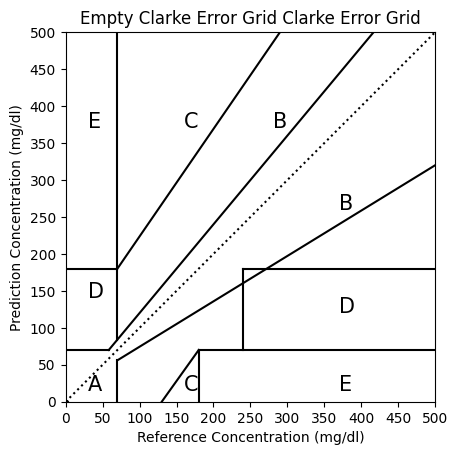

In [ ]:
clarke_error_grid([0], [0], "Empty Clarke Error Grid")

## Linear

### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2

x_train, y_train = read_windows(history=hl, horizon=hl)
x_val, y_val = read_windows(history=hl, horizon=hl, type='val')

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50)
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel


NameError: ignored

#### Results

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAIN RMSE

hl  = 8 #2h
hor = 2

x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
train_score = linear_model.evaluate(x_train, y_train)
print("########################################################################")
print()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TEST RMSE

hl  = 8 #2h
hor = 2

x_test, y_test = read_windows(history=hl, horizon=hl, type="test")


print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
test_score = linear_model.evaluate(x_test, y_test)
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_2.npy and windows/y_test_windows_history_8_horizon_2.npy...
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-Linear-hl8-hor2.pkl
125250/125250 [==============================] - 163s 1ms/step - loss: 18.4248 - RMSE: 18.4248
########################################################################



In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

np.save('output/Baseline30minResults.npy', BG_predicted_values_30_min)

In [ ]:
# Prediction
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl= 8 #2h
hor = 2

x_test, y_test = read_windows(history=hl, horizon=hl, type="test")

print("########################################################################")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
print("Predicting BG values...")
BG_baseline_predicted_values_30_min = linear_model.predict(x_test)
print("########################################################################")
print()

values = clarke_error_grid(y_test, BG_baseline_predicted_values_30_min, "General Baseline Model")

In [ ]:
BG_baseline_predicted_values_30_min

array([[252.28783],
       [266.12924],
       [242.58867],
       ...,
       [149.14812],
       [202.3666 ],
       [235.95702]], dtype=float32)

In [ ]:
values_zones = get_values_per_zone(values)
values_zones

{'A': 3547809, 'B': 412602, 'C': 1436, 'D': 45835, 'E': 305}

In [ ]:
predicted_values_len = y_test.shape[0]
predicted_values_len

4007987

In [ ]:
perc_values_zones = [value / predicted_values_len * 100 for value in values_zones.values()]

perc_values_zones = get_values_per_zone(perc_values_zones)
perc_values_zones

{'A': 88.51847573357897,
 'B': 10.29449446817068,
 'C': 0.03582845952344656,
 'D': 1.1435915336052738,
 'E': 0.007609805121623399}

### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
first_time = True      # Transfer learning

x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
if first_time:
  hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50,
      weights = f'output/best-Linear-hl{hl}-hor2.pkl')
else:
  hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 256, max_epochs = 500, early_stopping_patience=50,
      weights = f'output/best-Linear-hl{hl}-hor4.pkl')
print("########################################################################")
print()

#### Results

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAIN RMSE

hl  = 8 #2h
hor = 4

x_train, y_train = read_windows(history=hl, horizon=hl)

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
train_score = linear_model.evaluate(x_train, y_train)
print("########################################################################")
print()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TEST RMSE

hl  = 8 #2h
hor = 4

x_test, y_test = read_windows(history=hl, horizon=hl, type="test")

print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor{hor}.pkl')
test_score = linear_model.evaluate(x_test, y_test)
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_4.npy and windows/y_test_windows_history_8_horizon_4.npy...
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-Linear-hl8-hor4.pkl
122453/122453 [==============================] - 159s 1ms/step - loss: 33.4641 - RMSE: 33.4641
########################################################################



In [ ]:
# Prediction
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl= 8 #2h
hor = 4

x_test, y_test = read_windows(history=hl, horizon=hl, type="test")

print("########################################################################")
linear_model = prepare_model_linear(history_length=hl, weights= f'output/best-Linear-hl{hl}-hor2.pkl')
print("Predicting BG values...")
BG_baseline_predicted_values_60_min = linear_model.predict(x_test)
print("########################################################################")
print()
values = clarke_error_grid(y_test, BG_baseline_predicted_values_60_min, "General Baseline Model")


/content/gdrive/MyDrive/TFG/GeneralisticModel
Reading windows/x_test_windows_history_8_horizon_4.npy...
########################################################################
Weights: output/best-Linear-hl8-hor2.pkl
Loading weights...
Predicting BG values...
113305/122453 [==========================>...] - ETA: 7s

122453/122453 [==============================] - 106s 862us/step
########################################################################



In [ ]:
np.sqrt(np.mean((y_test - BG_baseline_predicted_values_60_min) ** 2))

36.84340164892819

In [ ]:
values_zones = get_values_per_zone(values)
values_zones

{'A': 2676677, 'B': 1085102, 'C': 23020, 'D': 127539, 'E': 6145}

In [ ]:
predicted_values_len = y_test.shape[0]
predicted_values_len

3918483

In [ ]:
perc_values_zones = [value / predicted_values_len * 100 for value in values_zones.values()]

perc_values_zones = get_values_per_zone(perc_values_zones)
perc_values_zones

{'A': 68.30901142100144,
 'B': 27.691889948227416,
 'C': 0.5874722437228896,
 'D': 3.2548054948815652,
 'E': 0.156820892166688}


# General Model Results By Complete Patients

## Creating Windows

In [ ]:
test_patients

array(['LIB193307', 'LIB193998', 'LIB193457', 'LIB193385', 'LIB193870',
       'LIB193914', 'LIB193536', 'LIB193957', 'LIB194041', 'LIB193725',
       'LIB193783', 'LIB194027', 'LIB194022', 'LIB193626', 'LIB194076',
       'LIB194007', 'LIB193515', 'LIB193349', 'LIB193476', 'LIB193350',
       'LIB193610', 'LIB193963', 'LIB193831', 'LIB193985', 'LIB193880',
       'LIB193410', 'LIB193795', 'LIB193868', 'LIB194044', 'LIB193675',
       'LIB193846', 'LIB193832', 'LIB193897', 'LIB193600', 'LIB193691',
       'LIB193591', 'LIB193984', 'LIB193837', 'LIB194121', 'LIB193647',
       'LIB194115', 'LIB193638', 'LIB194130', 'LIB193818', 'LIB194036',
       'LIB193523', 'LIB193763', 'LIB194104', 'LIB193320', 'LIB193859',
       'LIB193843', 'LIB193382', 'LIB193608', 'LIB193452', 'LIB194137',
       'LIB193587', 'LIB193659', 'LIB193939', 'LIB193893', 'LIB193486',
       'LIB193549', 'LIB193622', 'LIB193755', 'LIB194166', 'LIB193368',
       'LIB193602', 'LIB193542', 'LIB193833', 'LIB193584', 'LIB1

In [ ]:
# Generating the windows for training 30 min
history_lengths = [8] #2h
horizons = [2, 4]

for patient in test_patients:
  for hor in horizons:
    for hl in history_lengths:
      x_train, y_train = get_windows_one_step_walk_forward([df_glucose[df_glucose['Patient_ID'] == patient]['Measurement'].to_list()], hl, hor)
      np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/x_train_windows_history_{0}_horizon_{1}_{2}.npy'.format(hl, hor, patient), x_train)
      np.save('/content/gdrive/MyDrive/TFG/GeneralisticModel/windows/y_train_windows_history_{0}_horizon_{1}_{2}.npy'.format(hl, hor, patient), y_train)

### Unit testing

In [ ]:
# Checking all is okey

df_glucose[df_glucose['Patient_ID'] == 'LIB193319']['Measurement'].to_list()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

x_windows_patient_test = np.load('windows/x_train_windows_history_8_horizon_2_LIB193319.npy')
y_windows_patient_test = np.load('windows/y_train_windows_history_8_horizon_2_LIB193319.npy')

In [ ]:
x_windows_patient_test

In [ ]:
y_windows_patient_test

In [ ]:
df_glucose[df_glucose['Patient_ID'] == 'LIB193998']['Measurement'].to_list()

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

x_windows_patient_test = np.load('windows/x_train_windows_history_8_horizon_4_LIB193998.npy')
y_windows_patient_test = np.load('windows/y_train_windows_history_8_horizon_4_LIB193998.npy')

In [ ]:
x_windows_patient_test


In [ ]:
y_windows_patient_test


## General Model

###30 min

In [ ]:
test_patients = np.load('test_patients.npy')

Patient LIB193307
########################################################################
Reading windows/x_train_windows_history_8_horizon_2_LIB193307.npy and windows/y_train_windows_history_8_horizon_2_LIB193307.npy...
97527 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl
3048/3048 [==============================] - 20s 6ms/step - loss: 16.0107 - RMSE: 16.0112
RMSE: 16.01123809814453
########################################################################

########################################################################
Predicting BG values...
3048/3048 [==============================] - 16s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193998
########################################################################
Reading windows/x_train_windows_history_8_horizon_2_LIB193998.npy and windo

KeyboardInterrupt: ignored

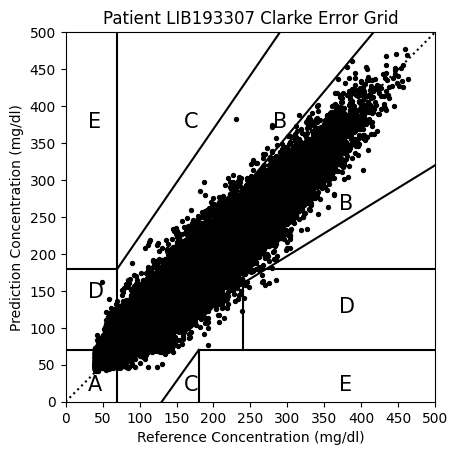

In [ ]:
test_scores_30, perc_zones_30 = get_stats_by_patient(hor=2)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
np.save('output/test_score_general_model_per_patient_30.npy', test_scores_30)
np.save('output/percentage_zones_general_model_per_patient_30.npy', perc_zones_30)

/content/gdrive/MyDrive/TFG/GeneralisticModel


NameError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
test_scores_30 = np.load('output/test_score_general_model_per_patient_30.npy', allow_pickle=True)
perc_zones_30  = np.load('output/percentage_zones_general_model_per_patient_30.npy', allow_pickle=True)

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
max_index = np.argmax(test_scores_30)
min_index = np.argmin(test_scores_30)

print(f"Best performance: Patient {test_patients[max_index]} --> {test_scores_30[min_index]}")
print(f"General model per patient worst performance: {test_patients[min_index]} --> {test_scores_30[max_index]}")
print(f"General model per patient mean performance: {np.mean(test_scores_30)}")
print(f"General model per patient standard deviation: {np.std(test_scores_30)}")

Best performance: Patient LIB193319 --> 10.954667091369629
General model per patient worst performance: LIB193353 --> 31.301921844482422
General model per patient mean performance: 18.05410553061444
General model per patient standard deviation: 3.0254836318521403


In [ ]:
# Calculating the 25th, 50th (median), and 75th percentiles
p25 = np.percentile(test_scores_30, 25)
p50 = np.percentile(test_scores_30, 50)
p75 = np.percentile(test_scores_30, 75)

# Printing the results
print("25th percentile:", p25)
print("50th percentile (median):", p50)
print("75th percentile:", p75)

25th percentile: 16.19505786895752
50th percentile (median): 17.817002296447754
75th percentile: 19.5917911529541


In [ ]:
for zone in perc_zones[0].keys():
  print(f"Zone {zone}:")
  print(f"Most number of points {max(perc_zones_30, key=lambda x: x[zone])[zone]}")
  print(f"Less number of points {min(perc_zones_30, key=lambda x: x[zone])[zone]}")

  print()

Zone A:
Most patient performance 96.11688744733092
Least patient performance 75.46323490147915

Zone B:
Most patient performance 18.545415709937522
Least patient performance 3.6830458637727728

Zone C:
Most patient performance 0.2776036536222799
Least patient performance 0.0

Zone D:
Most patient performance 6.051102296836086
Least patient performance 0.11240547721234416

Zone E:
Most patient performance 0.08180216461112509
Least patient performance 0.0



### 60 min

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193307
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193307.npy and windows/y_train_windows_history_8_horizon_4_LIB193307.npy...
96121 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
3004/3004 [==============================] - 17s 5ms/step - loss: 29.7310 - RMSE: 29.7319
RMSE: 29.73185157775879
########################################################################

########################################################################
Predicting BG values...
3004/3004 [==============================] - 16s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193998
########################################################################
Reading wi

2683/2683 [==============================] - 16s 5ms/step - loss: 34.0810 - RMSE: 34.0797
RMSE: 34.07974624633789
########################################################################

########################################################################
Predicting BG values...
2683/2683 [==============================] - 15s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193385
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193385.npy and windows/y_train_windows_history_8_horizon_4_LIB193385.npy...
87229 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
2726/2726 [==============================] - 15s 5ms/step - loss: 23.4683 - RMSE: 23.4684
RMSE: 23.468416213989258
################################

2280/2280 [==============================] - 14s 5ms/step - loss: 29.4521 - RMSE: 29.4465
RMSE: 29.446529388427734
########################################################################

########################################################################
Predicting BG values...
2280/2280 [==============================] - 13s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193957
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193957.npy and windows/y_train_windows_history_8_horizon_4_LIB193957.npy...
65513 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
2048/2048 [==============================] - 12s 5ms/step - loss: 30.2977 - RMSE: 30.2901
RMSE: 30.290084838867188
###############################

2061/2061 [==============================] - 12s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB194027
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194027.npy and windows/y_train_windows_history_8_horizon_4_LIB194027.npy...
64793 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
2025/2025 [==============================] - 12s 5ms/step - loss: 26.5528 - RMSE: 26.5539
RMSE: 26.553909301757812
########################################################################

########################################################################
Predicting BG values...
2025/2025 [==============================] - 11s 5ms/step
########################################################################

Number of valu

1743/1743 [==============================] - 10s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB194007
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194007.npy and windows/y_train_windows_history_8_horizon_4_LIB194007.npy...
55857 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1746/1746 [==============================] - 10s 5ms/step - loss: 47.5648 - RMSE: 47.5554
RMSE: 47.55535125732422
########################################################################

########################################################################
Predicting BG values...
1746/1746 [==============================] - 9s 5ms/step
########################################################################

Number of values

1743/1743 [==============================] - 10s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193350
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193350.npy and windows/y_train_windows_history_8_horizon_4_LIB193350.npy...
49866 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1559/1559 [==============================] - 9s 5ms/step - loss: 31.7188 - RMSE: 31.7113
RMSE: 31.711322784423828
########################################################################

########################################################################
Predicting BG values...
1559/1559 [==============================] - 8s 5ms/step
########################################################################

Number of values

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1616/1616 [==============================] - 9s 5ms/step - loss: 31.5098 - RMSE: 31.5069
RMSE: 31.506864547729492
########################################################################

########################################################################
Predicting BG values...
1616/1616 [==============================] - 9s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193880
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193880.npy and windows/y_train_windows_history_8_horizon_4_LIB193880.npy...
45888 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1434/1434 [==============================] - 9s 5ms/step - loss: 30.0173 - RMSE: 30.0173
R

1396/1396 [==============================] - 8s 5ms/step - loss: 32.6611 - RMSE: 32.6546
RMSE: 32.65464782714844
########################################################################

########################################################################
Predicting BG values...
1396/1396 [==============================] - 7s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB194044
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194044.npy and windows/y_train_windows_history_8_horizon_4_LIB194044.npy...
41028 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1283/1283 [==============================] - 8s 5ms/step - loss: 31.8742 - RMSE: 31.8657
RMSE: 31.865705490112305
###################################

1360/1360 [==============================] - 9s 5ms/step - loss: 34.4979 - RMSE: 34.4956
RMSE: 34.49555969238281
########################################################################

########################################################################
Predicting BG values...
1360/1360 [==============================] - 8s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193897
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193897.npy and windows/y_train_windows_history_8_horizon_4_LIB193897.npy...
41434 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1295/1295 [==============================] - 8s 5ms/step - loss: 32.4954 - RMSE: 32.4937
RMSE: 32.4936637878418
#####################################

1259/1259 [==============================] - 8s 5ms/step - loss: 35.2175 - RMSE: 35.1958
RMSE: 35.19575119018555
########################################################################

########################################################################
Predicting BG values...
1259/1259 [==============================] - 7s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193984
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193984.npy and windows/y_train_windows_history_8_horizon_4_LIB193984.npy...
39544 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1236/1236 [==============================] - 8s 6ms/step - loss: 31.0334 - RMSE: 31.0386
RMSE: 31.038625717163086
###################################

1246/1246 [==============================] - 7s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB194115
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194115.npy and windows/y_train_windows_history_8_horizon_4_LIB194115.npy...
37368 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1168/1168 [==============================] - 7s 5ms/step - loss: 24.3213 - RMSE: 24.3214
RMSE: 24.32143211364746
########################################################################

########################################################################
Predicting BG values...
1168/1168 [==============================] - 6s 5ms/step
########################################################################

Number of values o

Patient LIB194036
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194036.npy and windows/y_train_windows_history_8_horizon_4_LIB194036.npy...
36387 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1138/1138 [==============================] - 7s 5ms/step - loss: 37.4813 - RMSE: 37.5011
RMSE: 37.50107955932617
########################################################################

########################################################################
Predicting BG values...
1138/1138 [==============================] - 7s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193523
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193

1069/1069 [==============================] - 7s 6ms/step - loss: 31.7015 - RMSE: 31.7031
RMSE: 31.703136444091797
########################################################################

########################################################################
Predicting BG values...
1069/1069 [==============================] - 6s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193859
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193859.npy and windows/y_train_windows_history_8_horizon_4_LIB193859.npy...
33924 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
1061/1061 [==============================] - 7s 5ms/step - loss: 33.9877 - RMSE: 34.0321
RMSE: 34.032127380371094
##################################

991/991 [==============================] - 7s 5ms/step - loss: 29.5571 - RMSE: 29.5287
RMSE: 29.528709411621094
########################################################################

########################################################################
Predicting BG values...
991/991 [==============================] - 6s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193452
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193452.npy and windows/y_train_windows_history_8_horizon_4_LIB193452.npy...
30798 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
963/963 [==============================] - 6s 5ms/step - loss: 38.2960 - RMSE: 38.3173
RMSE: 38.31729507446289
#########################################

845/845 [==============================] - 6s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193939
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193939.npy and windows/y_train_windows_history_8_horizon_4_LIB193939.npy...
25862 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
809/809 [==============================] - 5s 5ms/step - loss: 19.9902 - RMSE: 19.9916
RMSE: 19.99162483215332
########################################################################

########################################################################
Predicting BG values...
809/809 [==============================] - 5s 5ms/step
########################################################################

Number of values outside

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
794/794 [==============================] - 5s 5ms/step - loss: 29.3196 - RMSE: 29.3202
RMSE: 29.32024383544922
########################################################################

########################################################################
Predicting BG values...
794/794 [==============================] - 4s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193755
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193755.npy and windows/y_train_windows_history_8_horizon_4_LIB193755.npy...
26390 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
825/825 [==============================] - 5s 5ms/step - loss: 31.5710 - RMSE: 31.5719
RMSE: 31

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
793/793 [==============================] - 5s 5ms/step - loss: 28.0124 - RMSE: 28.0134
RMSE: 28.013389587402344
########################################################################

########################################################################
Predicting BG values...
793/793 [==============================] - 4s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193542
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193542.npy and windows/y_train_windows_history_8_horizon_4_LIB193542.npy...
24124 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
754/754 [==============================] - 5s 6ms/step - loss: 38.9252 - RMSE: 38.9243
RMSE: 3

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
731/731 [==============================] - 5s 5ms/step - loss: 35.9067 - RMSE: 35.8781
RMSE: 35.87810134887695
########################################################################

########################################################################
Predicting BG values...
731/731 [==============================] - 4s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193545
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193545.npy and windows/y_train_windows_history_8_horizon_4_LIB193545.npy...
22299 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
697/697 [==============================] - 4s 5ms/step - loss: 32.3162 - RMSE: 32.3202
RMSE: 32

701/701 [==============================] - 5s 5ms/step - loss: 41.7832 - RMSE: 41.7860
RMSE: 41.78602981567383
########################################################################

########################################################################
Predicting BG values...
701/701 [==============================] - 4s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193408
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193408.npy and windows/y_train_windows_history_8_horizon_4_LIB193408.npy...
22808 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
713/713 [==============================] - 5s 5ms/step - loss: 28.2917 - RMSE: 28.2950
RMSE: 28.295001983642578
#########################################

649/649 [==============================] - 5s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193559
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193559.npy and windows/y_train_windows_history_8_horizon_4_LIB193559.npy...
21094 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
660/660 [==============================] - 4s 5ms/step - loss: 34.3943 - RMSE: 34.3795
RMSE: 34.379539489746094
########################################################################

########################################################################
Predicting BG values...
660/660 [==============================] - 4s 5ms/step
########################################################################

Number of values outsid

558/558 [==============================] - 4s 5ms/step - loss: 27.5780 - RMSE: 27.5817
RMSE: 27.581707000732422
########################################################################

########################################################################
Predicting BG values...
558/558 [==============================] - 4s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193490
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193490.npy and windows/y_train_windows_history_8_horizon_4_LIB193490.npy...
18045 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
564/564 [==============================] - 4s 5ms/step - loss: 33.9714 - RMSE: 33.9701
RMSE: 33.970123291015625
########################################

500/500 [==============================] - 4s 5ms/step - loss: 32.4386 - RMSE: 32.4362
RMSE: 32.43617630004883
########################################################################

########################################################################
Predicting BG values...
500/500 [==============================] - 3s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193318
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193318.npy and windows/y_train_windows_history_8_horizon_4_LIB193318.npy...
16062 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
502/502 [==============================] - 3s 5ms/step - loss: 35.1466 - RMSE: 35.1462
RMSE: 35.14623260498047
##########################################

472/472 [==============================] - 4s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193655
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193655.npy and windows/y_train_windows_history_8_horizon_4_LIB193655.npy...
14817 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
464/464 [==============================] - 3s 5ms/step - loss: 33.4007 - RMSE: 33.3316
RMSE: 33.33161163330078
########################################################################

########################################################################
Predicting BG values...
464/464 [==============================] - 3s 6ms/step
########################################################################

Number of values outside

########################################################################

Number of values outside the grid: [0]
Patient LIB194106
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194106.npy and windows/y_train_windows_history_8_horizon_4_LIB194106.npy...
13843 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
433/433 [==============================] - 3s 6ms/step - loss: 33.1502 - RMSE: 33.1614
RMSE: 33.16141128540039
########################################################################

########################################################################
Predicting BG values...
433/433 [==============================] - 3s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193650
######################

371/371 [==============================] - 3s 5ms/step - loss: 31.3402 - RMSE: 31.3432
RMSE: 31.34320831298828
########################################################################

########################################################################
Predicting BG values...
371/371 [==============================] - 2s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193418
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193418.npy and windows/y_train_windows_history_8_horizon_4_LIB193418.npy...
11897 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
372/372 [==============================] - 3s 5ms/step - loss: 32.4598 - RMSE: 32.4751
RMSE: 32.475120544433594
#########################################

365/365 [==============================] - 3s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193711
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193711.npy and windows/y_train_windows_history_8_horizon_4_LIB193711.npy...
11171 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
350/350 [==============================] - 3s 6ms/step - loss: 39.9169 - RMSE: 39.8597
RMSE: 39.8597412109375
########################################################################

########################################################################
Predicting BG values...
350/350 [==============================] - 2s 5ms/step
########################################################################

Number of values outside 

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
292/292 [==============================] - 2s 5ms/step - loss: 26.9968 - RMSE: 26.9898
RMSE: 26.989839553833008
########################################################################

########################################################################
Predicting BG values...
292/292 [==============================] - 2s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193863
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193863.npy and windows/y_train_windows_history_8_horizon_4_LIB193863.npy...
9117 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
285/285 [==============================] - 3s 6ms/step - loss: 30.5057 - RMSE: 30.5019
RMSE: 30

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
268/268 [==============================] - 2s 6ms/step - loss: 33.5887 - RMSE: 33.5770
RMSE: 33.57704544067383
########################################################################

########################################################################
Predicting BG values...
268/268 [==============================] - 2s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB194161
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194161.npy and windows/y_train_windows_history_8_horizon_4_LIB194161.npy...
8861 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
277/277 [==============================] - 2s 6ms/step - loss: 32.8511 - RMSE: 32.8554
RMSE: 32.

239/239 [==============================] - 3s 6ms/step - loss: 31.4519 - RMSE: 31.3778
RMSE: 31.377761840820312
########################################################################

########################################################################
Predicting BG values...
239/239 [==============================] - 2s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193800
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193800.npy and windows/y_train_windows_history_8_horizon_4_LIB193800.npy...
7329 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
230/230 [==============================] - 2s 5ms/step - loss: 37.1917 - RMSE: 37.1664
RMSE: 37.16641616821289
##########################################

200/200 [==============================] - 2s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193926
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193926.npy and windows/y_train_windows_history_8_horizon_4_LIB193926.npy...
6147 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
193/193 [==============================] - 2s 6ms/step - loss: 37.9394 - RMSE: 37.8331
RMSE: 37.83305740356445
########################################################################

########################################################################
Predicting BG values...
193/193 [==============================] - 2s 6ms/step
########################################################################

Number of values outside 

Patient LIB194108
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB194108.npy and windows/y_train_windows_history_8_horizon_4_LIB194108.npy...
5207 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
163/163 [==============================] - 2s 5ms/step - loss: 31.6056 - RMSE: 31.6155
RMSE: 31.615495681762695
########################################################################

########################################################################
Predicting BG values...
163/163 [==============================] - 1s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193801
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193801.

Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
124/124 [==============================] - 2s 6ms/step - loss: 40.1939 - RMSE: 40.2813
RMSE: 40.28129959106445
########################################################################

########################################################################
Predicting BG values...
124/124 [==============================] - 1s 5ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193796
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193796.npy and windows/y_train_windows_history_8_horizon_4_LIB193796.npy...
3776 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
118/118 [==============================] - 2s 6ms/step - loss: 29.8097 - RMSE: 29.8097
RMSE: 29.

110/110 [==============================] - 2s 6ms/step - loss: 39.6818 - RMSE: 39.6818
RMSE: 39.6817741394043
########################################################################

########################################################################
Predicting BG values...
110/110 [==============================] - 1s 6ms/step
########################################################################

Number of values outside the grid: [0]
Patient LIB193328
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193328.npy and windows/y_train_windows_history_8_horizon_4_LIB193328.npy...
3111 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
Loading weights...
98/98 [==============================] - 1s 6ms/step - loss: 31.7747 - RMSE: 31.7117
RMSE: 31.711746215820312
#############################################

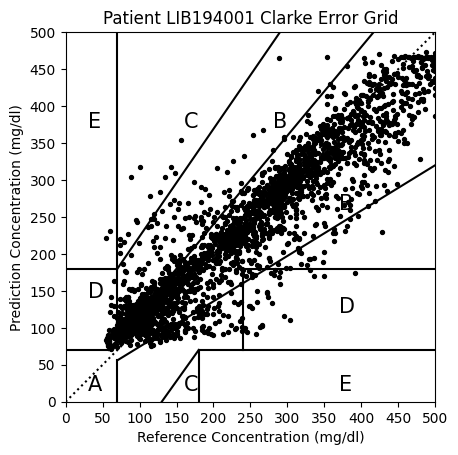

In [ ]:
test_scores_60, perc_zones_60 = get_stats_by_patient(hor=4)

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
np.save('output/test_score_general_model_per_patient_60.npy', test_scores_60)
np.save('output/percentage_zones_general_model_per_patient_60.npy', perc_zones_60)

/content/gdrive/MyDrive/TFG/GeneralisticModel


NameError: ignored

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
test_scores_60 = np.load('output/test_score_general_model_per_patient_60.npy', allow_pickle=True)
perc_zones_60 = np.load('output/percentage_zones_general_model_per_patient_60.npy', allow_pickle=True)

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
print(f"General model per patient best performance: {min(test_scores_60)}")
print(f"General model per patient worst performance: {max(test_scores_60)}")
print(f"General model per patient mean performance: {np.mean(test_scores_60)}")
print(f"General model per patient standard deviation: {np.std(test_scores_60)}")

General model per patient best performance: 19.99162483215332
General model per patient worst performance: 59.608680725097656
General model per patient mean performance: 33.0502076909162
General model per patient standard deviation: 6.021211026033608


In [ ]:
# Calculating the 25th, 50th (median), and 75th percentiles
p25 = np.percentile(test_scores_60, 25)
p50 = np.percentile(test_scores_60, 50)
p75 = np.percentile(test_scores_60, 75)

# Printing the results
print("25th percentile:", p25)
print("50th percentile (median):", p50)
print("75th percentile:", p75)

25th percentile: 29.466550827026367
50th percentile (median): 32.33056640625
75th percentile: 35.93110179901123


In [ ]:
for zone in perc_zones_60[0].keys():
  print(f"Zone {zone}:")
  print(f"Most number of points {max(perc_zones_60, key=lambda x: x[zone])[zone]}")
  print(f"Less number of points {min(perc_zones_60, key=lambda x: x[zone])[zone]}")

  print()

Zone A:
Most number of points 83.15513924370012
Less number of points 49.53004994897685

Zone B:
Most number of points 35.70347385150988
Less number of points 15.182767212287507

Zone C:
Most number of points 1.7565872020075282
Less number of points 0.0

Zone D:
Most number of points 17.870722433460077
Less number of points 0.42035122680283965

Zone E:
Most number of points 0.43914680050188204
Less number of points 0.0



### Boxplots

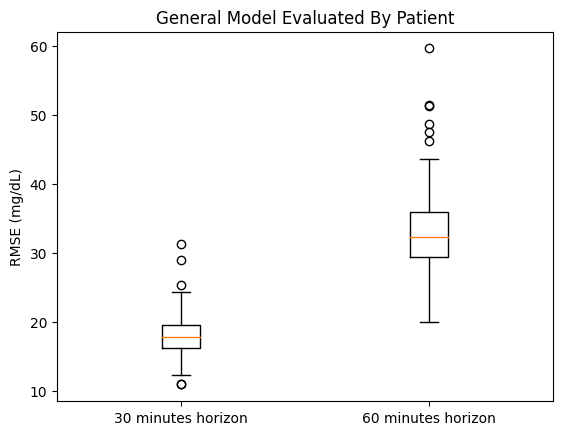

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and subplot
fig, ax = plt.subplots()

# Plotting the boxplots
ax.boxplot([test_scores_30, test_scores_60])

# Adding labels and titles
ax.set_title('General Model Evaluated By Patient')
ax.set_ylabel('RMSE (mg/dL)')
ax.set_xticklabels(['30 minutes horizon', '60 minutes horizon'])

# Display the plot
plt.show()

### Worst Patient LIB193319

#### 30 min

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
Reading windows/x_train_windows_history_8_horizon_2_LIB193319.npy and windows/y_train_windows_history_8_horizon_2_LIB193319.npy...
2420 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl
76/76 [==============================] - 2s 6ms/step - loss: 31.2963 - RMSE: 31.3019
RMSE: 31.301921844482422
########################################################################

########################################################################
Predicting BG values...
76/76 [==============================] - 1s 5ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [511.57852] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of v

([31.296316146850586, 31.301921844482422],
 {'A': 80.74380165289257,
  'B': 16.32231404958678,
  'C': 0.04132231404958678,
  'D': 2.8925619834710745,
  'E': 0.0})

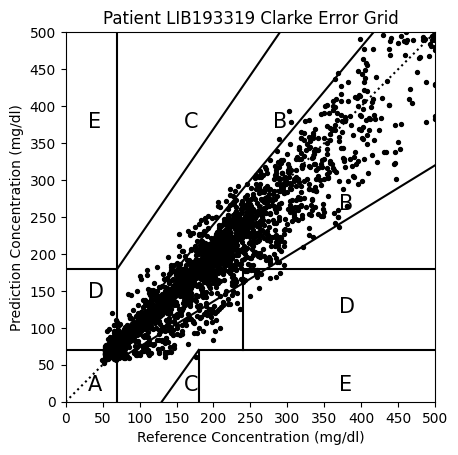

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193319', hor=2)

#### 60 min

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193319.npy and windows/y_train_windows_history_8_horizon_4_LIB193319.npy...
2305 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
73/73 [==============================] - 1s 6ms/step - loss: 59.0199 - RMSE: 59.6087
RMSE: 59.608680725097656
########################################################################

########################################################################
Predicting BG values...
73/73 [==============================] - 1s 5ms/step
########################################################################

Number of values outside the grid: [0]


([59.019901275634766, 59.608680725097656],
 {'A': 50.889370932754886,
  'B': 35.53145336225597,
  'C': 0.21691973969631237,
  'D': 13.36225596529284,
  'E': 0.0})

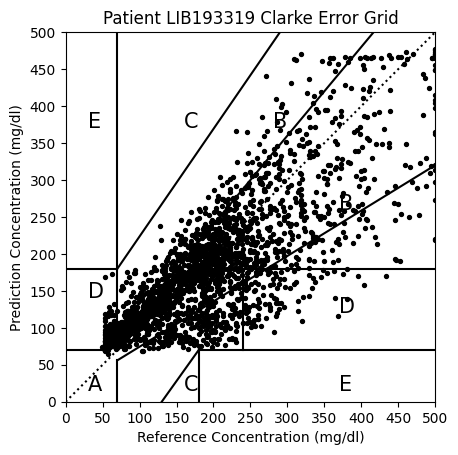

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193319', hor=4)

### Best patient 30 min LIB193353

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
Reading windows/x_train_windows_history_8_horizon_2_LIB193353.npy and windows/y_train_windows_history_8_horizon_2_LIB193353.npy...
12323 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl


386/386 [==============================] - 3s 6ms/step - loss: 10.9420 - RMSE: 10.9547
RMSE: 10.954667091369629
########################################################################

########################################################################
Predicting BG values...
386/386 [==============================] - 2s 5ms/step
########################################################################

Number of values outside the grid: [0]


([10.942039489746094, 10.954667091369629],
 {'A': 95.62606508155481,
  'B': 3.716627444615759,
  'C': 0.008114907084313883,
  'D': 0.6491925667451107,
  'E': 0.0})

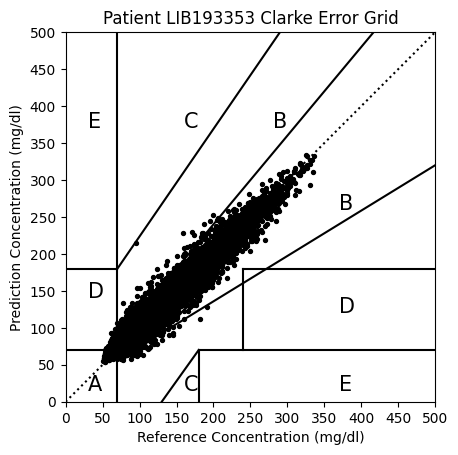

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193353', hor=2)

### Best patient 60 min LIB193939

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
Reading windows/x_train_windows_history_8_horizon_4_LIB193939.npy and windows/y_train_windows_history_8_horizon_4_LIB193939.npy...
25862 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
809/809 [==============================] - 7s 7ms/step - loss: 19.9902 - RMSE: 19.9916
RMSE: 19.99162483215332
########################################################################

########################################################################
Predicting BG values...
809/809 [==============================] - 4s 5ms/step
########################################################################

Number of values outside the grid: [0]


([19.990209579467773, 19.99162483215332],
 {'A': 62.323099528265416,
  'B': 27.217539246771327,
  'C': 0.003866676977805274,
  'D': 10.451627871007656,
  'E': 0.003866676977805274})

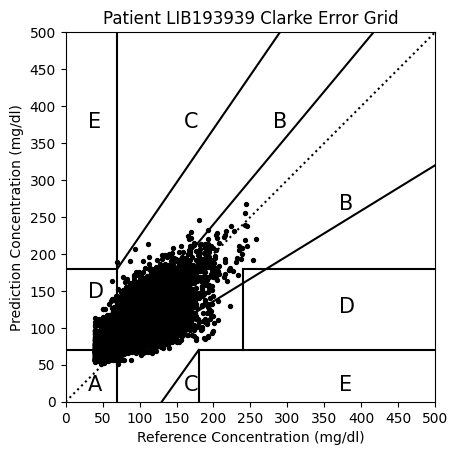

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193939', hor=4)

## General Model Comparative with persoanlized models

# Amount of data

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train  = x[:int(0.8*len(x))]
y_train  = y[:int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

windows_to_time(x_train, precision='days')

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 8
Number of Windows: 1936


20.166666666666668

In [ ]:
windows_to_time(x_test, precision='days')

History length: 8
Number of Windows: 484


5.041666666666667

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train  = x[:int(0.8*len(x))]
y_train  = y[:int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

windows_to_time(x_train, precision='days')

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 8
Number of Windows: 9858


102.6875

In [ ]:
windows_to_time(x_test, precision='days')

History length: 8
Number of Windows: 2465


25.677083333333332

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train  = x[:int(0.8*len(x))]
y_train  = y[:int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

windows_to_time(x_train, precision='days')

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 8
Number of Windows: 21598


224.97916666666666

In [ ]:
windows_to_time(x_test, precision='days')

History length: 8
Number of Windows: 5400


56.25

### LSTM

#### Worst Patient LIB193319

##### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl
16/16 [==============================] - 1s 7ms/step - loss: 32.4964 - RMSE: 33.3023
RMSE: 33.30229568481445
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 1s 6ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [506.52484] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [1]


([32.49640655517578, 33.30229568481445],
 {'A': 80.99173553719008,
  'B': 17.355371900826448,
  'C': 0.0,
  'D': 1.6528925619834711,
  'E': 0.0})

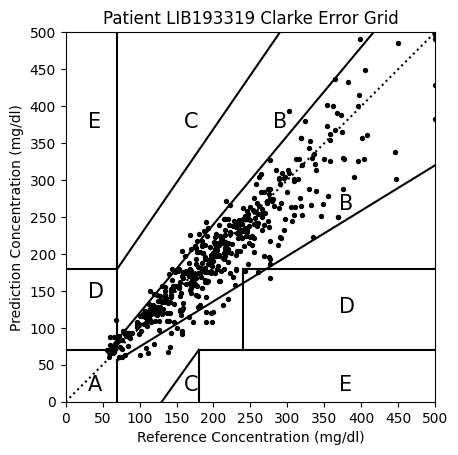

In [ ]:
show_results('LIB193319', hor=2, x_test=x_test, y_test=y_test)

##### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
15/15 [==============================] - 1s 6ms/step - loss: 56.8797 - RMSE: 55.9212
RMSE: 55.921207427978516
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 1s 7ms/step
########################################################################

Number of values outside the grid: [0]


([56.879669189453125, 55.921207427978516],
 {'A': 58.56832971800434,
  'B': 32.32104121475054,
  'C': 0.21691973969631237,
  'D': 8.893709327548807,
  'E': 0.0})

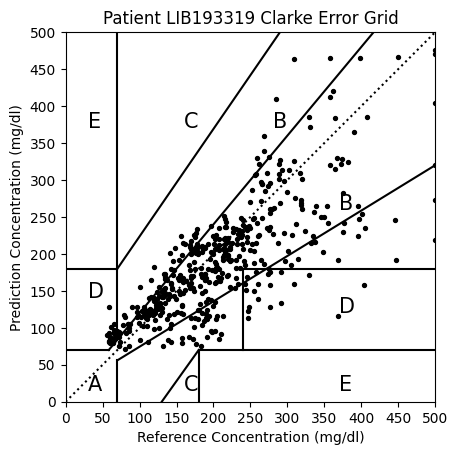

In [ ]:
show_results('LIB193319', hor=4, x_test=x_test, y_test=y_test)

#### Best patient 30 min LIB193353

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-LSTM-hl8-hor2.pkl
78/78 [==============================] - 1s 6ms/step - loss: 11.8074 - RMSE: 11.9432
RMSE: 11.9432373046875
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 1s 6ms/step
########################################################################

Number of values outside the grid: [0]


([11.807367324829102, 11.9432373046875],
 {'A': 94.52332657200812,
  'B': 4.705882352941177,
  'C': 0.0,
  'D': 0.7707910750507099,
  'E': 0.0})

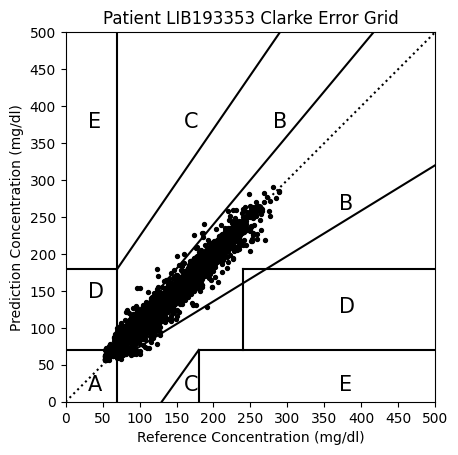

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193353', hor=2, x_test=x_test, y_test=y_test)

#### Best patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/TFG/GeneralisticModel'
/content


NameError: ignored

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-LSTM-hl8-hor4.pkl
162/162 [==============================] - 2s 7ms/step - loss: 20.9334 - RMSE: 20.9320
RMSE: 20.931974411010742
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 2s 6ms/step
########################################################################

Number of values outside the grid: [0]


([20.933420181274414, 20.931974411010742],
 {'A': 61.41503962884206,
  'B': 31.04581480765513,
  'C': 0.019331142470520007,
  'D': 7.519814421032282,
  'E': 0.0})

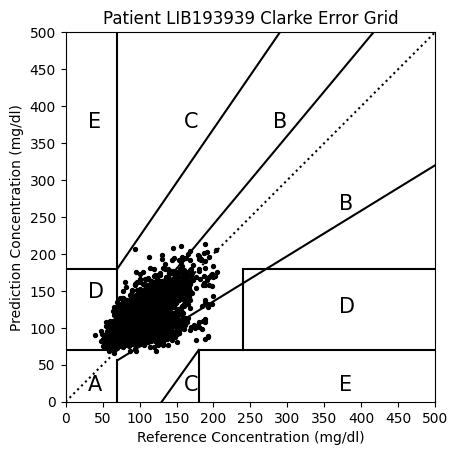

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193939', hor=4, x_test=x_test, y_test=y_test)

### Linear

#### Worst Patient LIB193319

##### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-Linear-hl8-hor2.pkl
16/16 [==============================] - 0s 2ms/step - loss: 32.7070 - RMSE: 33.5216
RMSE: 33.52159881591797
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 0s 1ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [516.74664] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [1]


([32.70697784423828, 33.52159881591797],
 {'A': 80.99173553719008,
  'B': 17.56198347107438,
  'C': 0.0,
  'D': 1.4462809917355373,
  'E': 0.0})

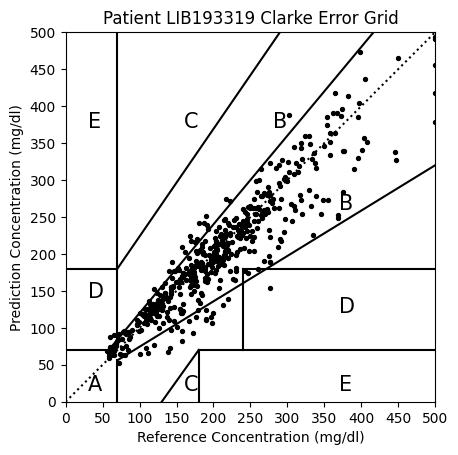

In [ ]:
show_results('LIB193319', kind=0, hor=2, x_test=x_test, y_test=y_test)

##### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-Linear-hl8-hor4.pkl
15/15 [==============================] - 0s 2ms/step - loss: 56.0718 - RMSE: 55.2123
RMSE: 55.212345123291016
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 0s 1ms/step
########################################################################

Number of values outside the grid: [0]


([56.07179260253906, 55.212345123291016],
 {'A': 57.26681127982647,
  'B': 35.140997830802604,
  'C': 0.21691973969631237,
  'D': 7.37527114967462,
  'E': 0.0})

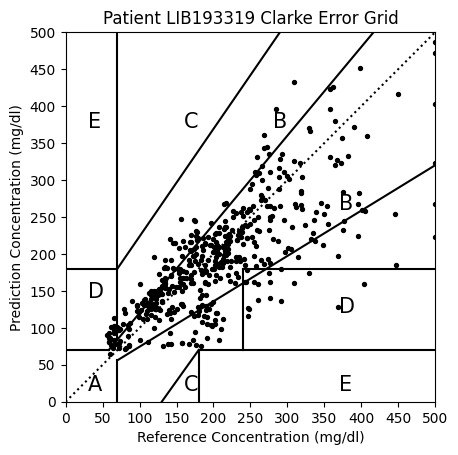

In [ ]:
show_results('LIB193319', kind=0, hor=4, x_test=x_test, y_test=y_test)

#### Best patient 30 min LIB193353

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-Linear-hl8-hor2.pkl
78/78 [==============================] - 0s 1ms/step - loss: 12.0530 - RMSE: 12.1998
RMSE: 12.19982624053955
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 0s 1ms/step
########################################################################

Number of values outside the grid: [0]


([12.052997589111328, 12.19982624053955],
 {'A': 94.4421906693712,
  'B': 4.9087221095334685,
  'C': 0.0,
  'D': 0.6490872210953347,
  'E': 0.0})

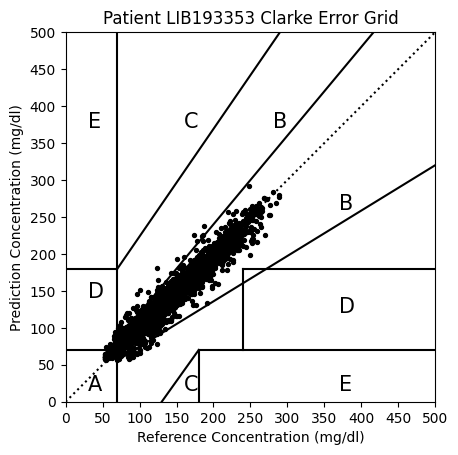

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193353', kind=0, hor=2, x_test=x_test, y_test=y_test)

#### Best patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-Linear-hl8-hor4.pkl
162/162 [==============================] - 0s 2ms/step - loss: 21.9036 - RMSE: 21.9023
RMSE: 21.902278900146484
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 0s 1ms/step
########################################################################

Number of values outside the grid: [0]


([21.90358543395996, 21.902278900146484],
 {'A': 56.1376377343901,
  'B': 36.265223274695536,
  'C': 0.0,
  'D': 7.597138990914363,
  'E': 0.0})

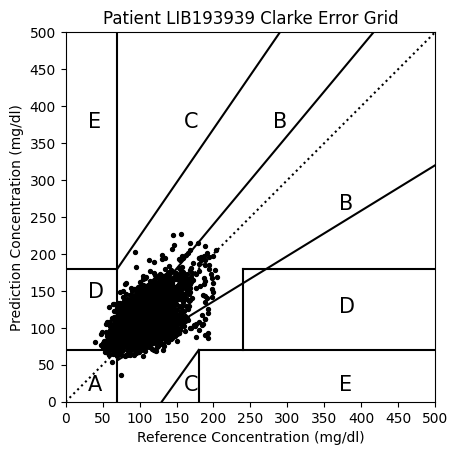

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193939', kind=0, hor=4, x_test=x_test, y_test=y_test)

# Personalized Model

## LSTM Model

### Worst Patient LIB193319

#### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
INFO: Training without validation
Epoch 1/1000
61/61 [==============================] - 4s 35ms/step - loss: 205.3575 - RMSE: 205.1109
Epoch 2/1000
61/61 [==============================] - 1s 12ms/step - loss: 193.4622 - RMSE: 193.2240
Epoch 3/1000
61/61 [==============================] - 1s 13ms/step - loss: 184.8530 - RMSE: 184.8773
Epoch 4/1000
61/61 [==============================] - 1s 13ms/step - loss: 178.5885 - RMSE: 178.2029
Epoch 5/1000
61/61 [==============================] - 1s 13ms/step - loss: 172.8040 - RMSE: 172.9653
Epoch 6/1000
61/61 [==============================] - 1s 13ms/step - loss: 167.2619 - RMSE: 167.3660
Epoch 7/1000
61/61 [==============================] - 1s 11ms/step - loss: 162.0064 - RMSE: 161.8428
Epoch 8/1000
61/61 [==============================] - 1s 11ms/step - loss: 156.7259 - RMSE: 156.8199
Epoch 9/1

In [ ]:
hist.history

Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193319-LSTM-hl8-hor2.pkl
16/16 [==============================] - 1s 5ms/step - loss: 32.4427 - RMSE: 33.3427
RMSE: 33.34273910522461
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 0s 5ms/step
########################################################################

Number of values outside the grid: [0]


([32.442691802978516, 33.34273910522461],
 {'A': 80.37190082644628,
  'B': 18.388429752066116,
  'C': 0.0,
  'D': 1.2396694214876034,
  'E': 0.0})

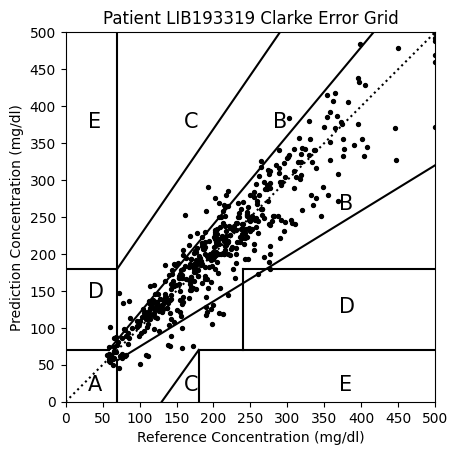

In [ ]:
show_results('LIB193319', hor=2, kind=3, x_test=x_test, y_test=y_test)

#### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'

# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor,
        batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')

print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
INFO: Training without validation
Epoch 1/1000
58/58 [==============================] - 3s 17ms/step - loss: 204.4034 - RMSE: 204.3382
Epoch 2/1000
58/58 [==============================] - 1s 14ms/step - loss: 193.9623 - RMSE: 193.8792
Epoch 3/1000
58/58 [==============================] - 1s 15ms/step - loss: 185.9611 - RMSE: 186.2547
Epoch 4/1000
58/58 [==============================] - 1s 15ms/step - loss: 179.3450 - RMSE: 179.4065
Epoch 5/1000
58/58 [==============================] - 1s 15ms/step - loss: 173.5342 - RMSE: 173.2971
Epoch 6/1000
58/58 [==============================] - 1s 15ms/step - loss: 168.1806 - RMSE: 168.1865
Epoch 7/1000
58/58 [==============================] - 1s 16ms/step - loss: 162.8741 - RMSE: 162.5633
Epoch 8/1000
58/58 [==============================] - 1s 16ms/step - loss: 157.9469 - RMSE: 157.9082
Epoch 9/1

Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193319-LSTM-hl8-hor4.pkl
15/15 [==============================] - 1s 6ms/step - loss: 58.7730 - RMSE: 58.2605
RMSE: 58.26048278808594
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 1s 6ms/step
########################################################################

Number of values outside the grid: [0]


([58.77302169799805, 58.26048278808594],
 {'A': 53.36225596529284,
  'B': 39.91323210412148,
  'C': 1.5184381778741864,
  'D': 4.772234273318872,
  'E': 0.43383947939262474})

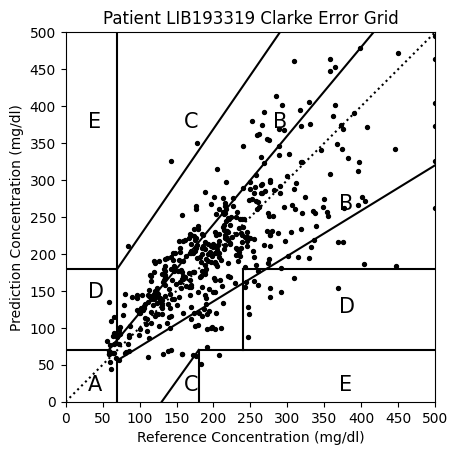

In [ ]:
show_results('LIB193319', hor=4, kind=3, x_test=x_test, y_test=y_test)

### Best patient 30 min LIB193353

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
print(len(x_train))
print(len(x_test))

9858
2465


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'

# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
INFO: Training without validation
Epoch 1/1000
309/309 [==============================] - 5s 10ms/step - loss: 129.5046 - RMSE: 129.3775
Epoch 2/1000
309/309 [==============================] - 3s 10ms/step - loss: 95.5256 - RMSE: 95.3217
Epoch 3/1000
309/309 [==============================] - 3s 10ms/step - loss: 69.7064 - RMSE: 69.6006
Epoch 4/1000
309/309 [==============================] - 4s 13ms/step - loss: 49.2954 - RMSE: 49.2529
Epoch 5/1000
309/309 [==============================] - 4s 13ms/step - loss: 34.7624 - RMSE: 34.8791
Epoch 6/1000
309/309 [==============================] - 3s 10ms/step - loss: 25.0431 - RMSE: 25.0237
Epoch 7/1000
309/309 [==============================] - 3s 11ms/step - loss: 18.6450 - RMSE: 18.6055
Epoch 8/1000
309/309 [==============================] - 3s 11ms/step - loss: 14.9232 - RMSE: 14.9178
Epoch 9

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193353-LSTM-hl8-hor2.pkl
78/78 [==============================] - 1s 6ms/step - loss: 12.0838 - RMSE: 12.1737
RMSE: 12.173662185668945
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 1s 6ms/step
########################################################################

Number of values outside the grid: [0]


([12.083818435668945, 12.173662185668945],
 {'A': 94.19878296146045,
  'B': 5.314401622718052,
  'C': 0.0,
  'D': 0.486815415821501,
  'E': 0.0})

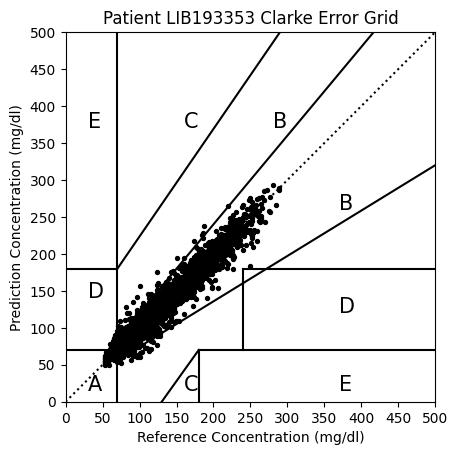

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193353', hor=2, kind=3, x_test=x_test, y_test=y_test)

### Best patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193939'
first_time = True
# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
INFO: Training without validation
Epoch 1/1000
647/647 [==============================] - 10s 12ms/step - loss: 55.1344 - RMSE: 55.1083
Epoch 2/1000
647/647 [==============================] - 8s 12ms/step - loss: 19.2783 - RMSE: 19.2728
Epoch 3/1000
647/647 [==============================] - 7s 11ms/step - loss: 14.3587 - RMSE: 14.3568
Epoch 4/1000
647/647 [==============================] - 7s 11ms/step - loss: 13.3459 - RMSE: 13.3417
Epoch 5/1000
647/647 [==============================] - 7s 11ms/step - loss: 12.9496 - RMSE: 12.9493
Epoch 6/1000
647/647 [==============================] - 7s 11ms/step - loss: 12.7151 - RMSE: 12.7141
Epoch 7/1000
647/647 [==============================] - 7s 11ms/step - loss: 12.5676 - RMSE: 12.5690
Epoch 8/1000
647/647 [==============================] - 8s 12ms/step - loss: 12.4824 - RMSE: 12.4806
Epoch 9/

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193939-LSTM-hl8-hor4.pkl
162/162 [==============================] - 2s 6ms/step - loss: 18.2753 - RMSE: 18.2869
RMSE: 18.28694725036621
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 1s 5ms/step
########################################################################

Number of values outside the grid: [0]


([18.27528190612793, 18.28694725036621],
 {'A': 76.57065532572975,
  'B': 20.54900444616277,
  'C': 0.0,
  'D': 2.8803402281074812,
  'E': 0.0})

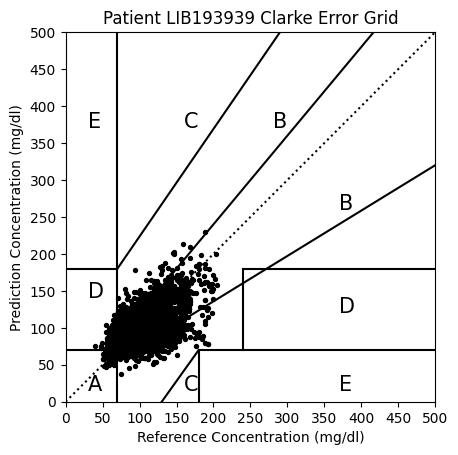

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193939', hor=4, kind=3, x_test=x_test, y_test=y_test)

## Linear Model

### Worst Patient LIB193319

#### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()


/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
Epoch 1/1000
61/61 [==============================] - 1s 5ms/step - loss: 127.3594 - RMSE: 126.9770
Epoch 2/1000
42/61 [===================>..........] - ETA: 0s - loss: 65.6548 - RMSE: 65.6548

61/61 [==============================] - 0s 7ms/step - loss: 61.3313 - RMSE: 61.1809
Epoch 3/1000
61/61 [==============================] - 0s 2ms/step - loss: 50.3044 - RMSE: 50.2364
Epoch 4/1000
61/61 [==============================] - 0s 2ms/step - loss: 49.1697 - RMSE: 49.1241
Epoch 5/1000
61/61 [==============================] - 0s 2ms/step - loss: 48.3692 - RMSE: 48.3625
Epoch 6/1000
61/61 [==============================] - 0s 2ms/step - loss: 47.3230 - RMSE: 47.3320
Epoch 7/1000
61/61 [==============================] - 0s 2ms/step - loss: 46.4441 - RMSE: 46.5345
Epoch 8/1000
61/61 [==============================] - 0s 2ms/step - loss: 45.7989 - RMSE: 45.7560
Epoch 9/1000
61/61 [==============================] - 0s 2ms/step - loss: 44.9880 - RMSE: 44.9975
Epoch 10/1000
61/61 [==============================] - 0s 2ms/step - loss: 44.4075 - RMSE: 44.3506
Epoch 11/1000
61/61 [==============================] - 0s 2ms/step - loss: 43.7925 - RMSE: 43.7175
Epoch 12/1000
61/61 [==========

Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193319-Linear-hl8-hor2.pkl
16/16 [==============================] - 0s 2ms/step - loss: 33.8184 - RMSE: 34.4628
RMSE: 34.46282196044922
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 0s 2ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [529.22394] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [2]


([33.81844711303711, 34.46282196044922],
 {'A': 77.27272727272727,
  'B': 20.454545454545457,
  'C': 0.0,
  'D': 2.272727272727273,
  'E': 0.0})

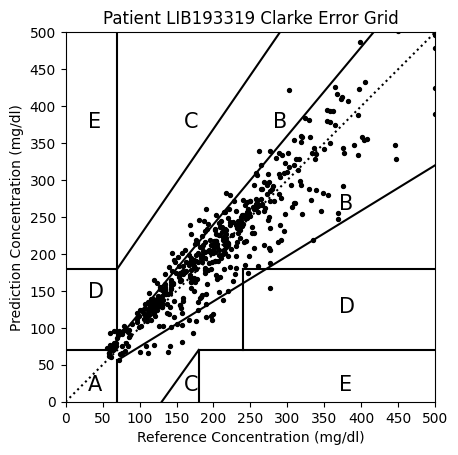

In [ ]:
show_results('LIB193319', hor=2, kind=2, x_test=x_test, y_test=y_test)

#### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'
# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
Epoch 1/1000


647/647 [==============================] - 2s 2ms/step - loss: 65.7260 - RMSE: 65.7023
Epoch 2/1000
647/647 [==============================] - 1s 2ms/step - loss: 20.7916 - RMSE: 20.7913
Epoch 3/1000
647/647 [==============================] - 1s 2ms/step - loss: 18.5109 - RMSE: 18.5112
Epoch 4/1000
647/647 [==============================] - 1s 2ms/step - loss: 17.0541 - RMSE: 17.0530
Epoch 5/1000
647/647 [==============================] - 1s 2ms/step - loss: 16.1025 - RMSE: 16.0972
Epoch 6/1000
647/647 [==============================] - 1s 1ms/step - loss: 15.5057 - RMSE: 15.5030
Epoch 7/1000
647/647 [==============================] - 1s 1ms/step - loss: 15.0928 - RMSE: 15.0898
Epoch 8/1000
647/647 [==============================] - 1s 1ms/step - loss: 14.7698 - RMSE: 14.7710
Epoch 9/1000
647/647 [==============================] - 1s 1ms/step - loss: 14.5258 - RMSE: 14.5250
Epoch 10/1000
647/647 [==============================] - 1s 1ms/step - loss: 14.3044 - RMSE: 14.3065
Epoch 11/100

Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193319-Linear-hl8-hor4.pkl
15/15 [==============================] - 0s 2ms/step - loss: 59.0287 - RMSE: 58.0173
RMSE: 58.01729202270508
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 0s 2ms/step
########################################################################

Number of values outside the grid: [0]


([59.02874755859375, 58.01729202270508],
 {'A': 59.869848156182215,
  'B': 32.32104121475054,
  'C': 0.0,
  'D': 7.592190889370933,
  'E': 0.21691973969631237})

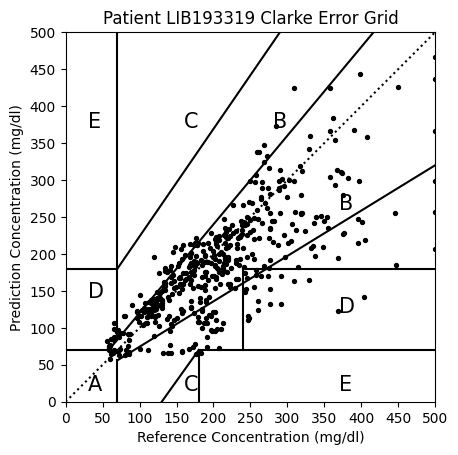

In [ ]:
show_results('LIB193319', hor=4, kind=2, x_test=x_test, y_test=y_test)

### Best patient 30 min LIB193353

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'

# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
Epoch 1/1000
309/309 [==============================] - 1s 2ms/step - loss: 80.1780 - RMSE: 79.9633
Epoch 2/1000
309/309 [==============================] - 0s 1ms/step - loss: 39.8904 - RMSE: 39.8313
Epoch 3/1000
309/309 [==============================] - 0s 1ms/step - loss: 34.8620 - RMSE: 34.8422
Epoch 4/1000
309/309 [==============================] - 0s 1ms/step - loss: 28.9437 - RMSE: 28.9373
Epoch 5/1000
309/309 [==============================] - 0s 1ms/step - loss: 22.9624 - RMSE: 22.9713
Epoch 6/1000
309/309 [==============================] - 0s 1ms/step - loss: 17.9872 - RMSE: 17.9922
Epoch 7/1000
309/309 [==============================] - 0s 2ms/step - loss: 14.9392 - RMSE: 14.9039
Epoch 8/1000
309/309 [==============================] - 0s 2ms/step - loss: 13.6035 - RMSE: 13.5743
Epoch 9/1000
309/309 [=============================

Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193353-Linear-hl8-hor2.pkl
78/78 [==============================] - 0s 2ms/step - loss: 12.3170 - RMSE: 12.4116
RMSE: 12.411641120910645
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 0s 1ms/step
########################################################################

Number of values outside the grid: [0]


([12.316956520080566, 12.411641120910645],
 {'A': 93.9553752535497,
  'B': 5.679513184584178,
  'C': 0.0,
  'D': 0.36511156186612576,
  'E': 0.0})

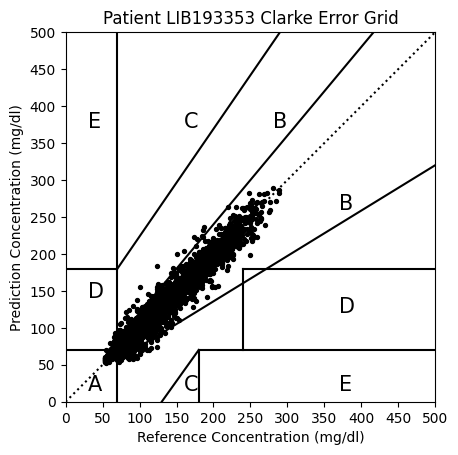

In [ ]:
show_results('LIB193353', hor=2, kind=2, x_test=x_test, y_test=y_test)

### Best patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

x_train = x[:int(0.8*len(x))]
y_train = y[:int(0.8*len(y))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193939'
first_time = True
# Note: After 1000 epochs doesn't stop with early stopping
print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
Epoch 1/1000
647/647 [==============================] - 1s 1ms/step - loss: 28.2697 - RMSE: 28.2642
Epoch 2/1000
647/647 [==============================] - 1s 1ms/step - loss: 15.6766 - RMSE: 15.6756
Epoch 3/1000
647/647 [==============================] - 1s 2ms/step - loss: 14.2552 - RMSE: 14.2557
Epoch 4/1000
647/647 [==============================] - 1s 2ms/step - loss: 13.8731 - RMSE: 13.8730
Epoch 5/1000
647/647 [==============================] - 1s 2ms/step - loss: 13.7195 - RMSE: 13.7162
Epoch 6/1000
647/647 [==============================] - 1s 1ms/step - loss: 13.6356 - RMSE: 13.6360
Epoch 7/1000
647/647 [==============================] - 1s 1ms/step - loss: 13.5311 - RMSE: 13.5394
Epoch 8/1000
647/647 [==============================] - 1s 1ms/step - loss: 13.4801 - RMSE: 13.4818
Epoch 9/1000
647/647 [=============================

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193939-Linear-hl8-hor4.pkl
162/162 [==============================] - 0s 2ms/step - loss: 18.3820 - RMSE: 18.3956
RMSE: 18.39557647705078
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 0s 1ms/step
########################################################################

Number of values outside the grid: [0]


([18.382043838500977, 18.39557647705078],
 {'A': 76.37734390102455,
  'B': 20.95495843804369,
  'C': 0.0,
  'D': 2.6676976609317613,
  'E': 0.0})

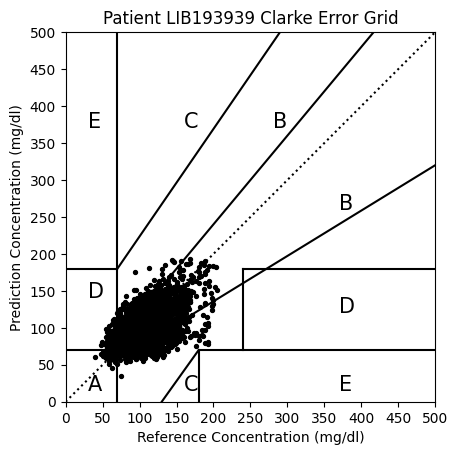

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
show_results('LIB193939', hor=4, kind=2, x_test=x_test, y_test=y_test)

## Personalized with Tuning Process

### Worst PatienT LIB193319

#### Tuning

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_train = x[:int(0.7*len(x))]
y_train = y[:int(0.7*len(y))]
x_val = x[int(0.7*len(x)):int(0.8*len(x))]
y_val = y[int(0.7*len(x)):int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TUNING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

for hu in [256, 512, 1024]:

  print("########################################################################")
  print(f"History lenght: {hl}, Horizon: {hor}, Hidden units: {hu}")
  hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = hu,
        batch_size = 32, max_epochs = 500, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-tuning{hu}-')
  print("########################################################################")
  print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2, Hidden units: 256
INFO: Training without validation
Epoch 1/500
53/53 [==============================] - 63s 23ms/step - loss: 199.2894 - RMSE: 199.3031
Epoch 2/500
53/53 [==============================] - 1s 25ms/step - loss: 183.2043 - RMSE: 183.1948
Epoch 3/500
53/53 [==============================] - 1s 24ms/step - loss: 170.2719 - RMSE: 170.2743
Epoch 4/500
53/53 [==============================] - 1s 27ms/step - loss: 159.5620 - RMSE: 159.5704
Epoch 5/500
53/53 [==============================] - 1s 21ms/step - loss: 148.9245 - RMSE: 148.9179
Epoch 6/500
53/53 [==============================] - 1s 21ms/step - loss: 140.5878 - RMSE: 140.5830
Epoch 7/500
53/53 [==============================] - 1s 21ms/step - loss: 132.2628 - RMSE: 132.2137
Epoch 8/500
53/53 [==============================] - 1s 22ms/step - loss: 125.5938 - RMSE: 125.59

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

for hu in [256, 512, 1024]:

  model = prepare_model_LSTM(history_length=hl, nb_hidden_units=hu,
                               weights= f'output/best-personalized{patient_id}-tuning{hu}-LSTM-hl{hl}-hor{hor}.pkl')

  test_score = model.evaluate(x_val, y_val)
  print(f"RMSE: {test_score[1]}")

/content/gdrive/MyDrive/TFG/GeneralisticModel
Weights: output/best-personalizedLIB193319-tuning256-LSTM-hl8-hor2.pkl
8/8 [==============================] - 1s 10ms/step - loss: 30.2204 - RMSE: 30.7624
RMSE: 30.762439727783203
Weights: output/best-personalizedLIB193319-tuning512-LSTM-hl8-hor2.pkl
8/8 [==============================] - 1s 15ms/step - loss: 27.7748 - RMSE: 27.9976
RMSE: 27.997636795043945


Weights: output/best-personalizedLIB193319-tuning1024-LSTM-hl8-hor2.pkl
8/8 [==============================] - 1s 44ms/step - loss: 26.3583 - RMSE: 26.6021
RMSE: 26.602073669433594


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'


for dropout in [0, 0.1, 0.2]:

  print("########################################################################")
  print(f"History lenght: {hl}, Horizon: {hor}")
  hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = 1024, dropout=dropout,
        batch_size = 32, max_epochs = 50, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}-tuning1024-dropout{dropout}-')
  print("########################################################################")
  print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
INFO: Training without validation
Epoch 1/50
53/53 [==============================] - 18s 288ms/step - loss: 172.6942 - RMSE: 172.6750
Epoch 2/50
53/53 [==============================] - 14s 272ms/step - loss: 132.9960 - RMSE: 132.9694
Epoch 3/50
53/53 [==============================] - 15s 282ms/step - loss: 110.4588 - RMSE: 110.4304
Epoch 4/50
53/53 [==============================] - 14s 256ms/step - loss: 94.2525 - RMSE: 94.2526
Epoch 5/50
53/53 [==============================] - 14s 255ms/step - loss: 76.4158 - RMSE: 76.4362
Epoch 6/50
53/53 [==============================] - 14s 255ms/step - loss: 65.0220 - RMSE: 65.0240
Epoch 7/50
53/53 [==============================] - 13s 253ms/step - loss: 56.2632 - RMSE: 56.2445
Epoch 8/50
53/53 [==============================] - 13s 254ms/step - loss: 49.8564 - RMSE: 49.8603
Epoch 9/50
53/53 [=

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

for layer in [1,2]:
  for dropout in [0, 0.1, 0.2]:

    model = prepare_model_LSTM(history_length=hl, nb_hidden_units=1024, nb_layers=layer, dropout=dropout,
                                weights= f'output/best-personalized{patient_id}-tuning{hu}-layer{layer}-dropout{dropout}-LSTM-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")

/content/gdrive/MyDrive/TFG/GeneralisticModel


NameError: ignored

#### Training

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'


print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = 1024,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}withTuning-')
print("########################################################################")
print()

#### Results

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2


Weights: output/best-personalizedLIB193319withTuning-LSTM-hl8-hor2.pkl
16/16 [==============================] - 2s 69ms/step - loss: 36.9836 - RMSE: 37.1778
RMSE: 37.177799224853516
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 2s 79ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [503.97015] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [1]


([36.983558654785156, 37.177799224853516],
 {'A': 74.3801652892562,
  'B': 23.553719008264462,
  'C': 0.4132231404958678,
  'D': 1.6528925619834711,
  'E': 0.0})

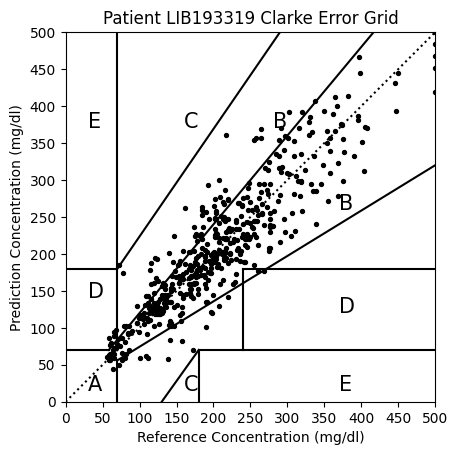

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193319', hor=2, kind=4, x_test=x_test, y_test=y_test, hidden_units=1024)

### Worst Patient 60 min LIB193319

#### Tuning

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)

y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_train = x[:int(0.7*len(x))]
y_train = y[:int(0.7*len(y))]
x_val = x[int(0.7*len(x)):int(0.8*len(x))]
y_val = y[int(0.7*len(x)):int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TUNING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'

for hu in [1024]:

  print("########################################################################")
  print(f"History lenght: {hl}, Horizon: {hor}, Hidden units: {hu}")
  hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = hu,
        batch_size = 32, max_epochs = 500, early_stopping_patience=50,
               extra_info_name =f'personalized{patient_id}-tuning{hu}-')
  print("########################################################################")
  print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4, Hidden units: 1024
INFO: Training without validation
Epoch 1/500
51/51 [==============================] - 18s 302ms/step - loss: 174.6836 - RMSE: 174.3244
Epoch 2/500
51/51 [==============================] - 13s 255ms/step - loss: 137.7022 - RMSE: 137.5545
Epoch 3/500
51/51 [==============================] - 13s 256ms/step - loss: 113.8869 - RMSE: 113.9487
Epoch 4/500
51/51 [==============================] - 13s 261ms/step - loss: 101.1496 - RMSE: 100.6878
Epoch 5/500
51/51 [==============================] - 13s 252ms/step - loss: 89.7995 - RMSE: 90.1613
Epoch 6/500
51/51 [==============================] - 13s 251ms/step - loss: 81.0972 - RMSE: 81.0878
Epoch 7/500
51/51 [==============================] - 13s 253ms/step - loss: 75.9159 - RMSE: 76.0306
Epoch 8/500
51/51 [==============================] - 13s 258ms/step - loss: 72.5942 - RMS

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'

for hu in [256, 512, 1024]:

  model = prepare_model_LSTM(history_length=hl, nb_hidden_units=hu,
                               weights= f'output/best-personalized{patient_id}-tuning{hu}-LSTM-hl{hl}-hor{hor}.pkl')

  test_score = model.evaluate(x_val, y_val)
  print(f"RMSE: {test_score[1]}")

#### Training

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'


print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = 256,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}withTuning-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
INFO: Training without validation
Epoch 1/1000


KeyboardInterrupt: ignored

#### Results

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193319withTuning-LSTM-hl8-hor4.pkl
15/15 [==============================] - 1s 14ms/step - loss: 71.6564 - RMSE: 70.5077
RMSE: 70.50769805908203
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 1s 13ms/step
########################################################################

Number of values outside the grid: [0]


([71.65635681152344, 70.50769805908203],
 {'A': 46.420824295010846,
  'B': 40.99783080260303,
  'C': 6.941431670281996,
  'D': 5.42299349240781,
  'E': 0.21691973969631237})

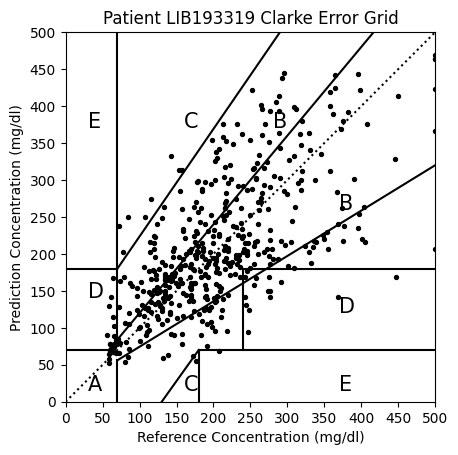

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193319', hor=4, kind=4, x_test=x_test, y_test=y_test, hidden_units=256)

### Best Patient 30 min LIB193353

In [ ]:

%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)

y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_train = x[:int(0.7*len(x))]
y_train = y[:int(0.7*len(y))]
x_val = x[int(0.7*len(x)):int(0.8*len(x))]
y_val = y[int(0.7*len(x)):int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'


print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = 1024,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}withTuning-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 2
INFO: Training without validation
Epoch 1/1000
270/270 [==============================] - 75s 267ms/step - loss: 61.4887 - RMSE: 61.4403
Epoch 2/1000
270/270 [==============================] - 69s 256ms/step - loss: 15.5394 - RMSE: 15.5412
Epoch 3/1000
270/270 [==============================] - 70s 259ms/step - loss: 12.2045 - RMSE: 12.2026
Epoch 4/1000
270/270 [==============================] - 73s 269ms/step - loss: 11.6717 - RMSE: 11.6713
Epoch 5/1000
270/270 [==============================] - 72s 267ms/step - loss: 11.5577 - RMSE: 11.5686
Epoch 6/1000
270/270 [==============================] - 68s 253ms/step - loss: 11.3401 - RMSE: 11.3459
Epoch 7/1000
270/270 [==============================] - 71s 264ms/step - loss: 11.3180 - RMSE: 11.3234
Epoch 8/1000
270/270 [==============================] - 74s 276ms/step - loss: 11.3088 - RMSE: 1

KeyboardInterrupt: ignored

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2


Weights: output/best-personalizedLIB193353withTuning-LSTM-hl8-hor2.pkl
78/78 [==============================] - 5s 53ms/step - loss: 12.0297 - RMSE: 12.0803
RMSE: 12.080278396606445
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 5s 58ms/step
########################################################################

Number of values outside the grid: [0]


([12.029720306396484, 12.080278396606445],
 {'A': 94.40162271805274,
  'B': 5.152129817444219,
  'C': 0.0,
  'D': 0.4462474645030426,
  'E': 0.0})

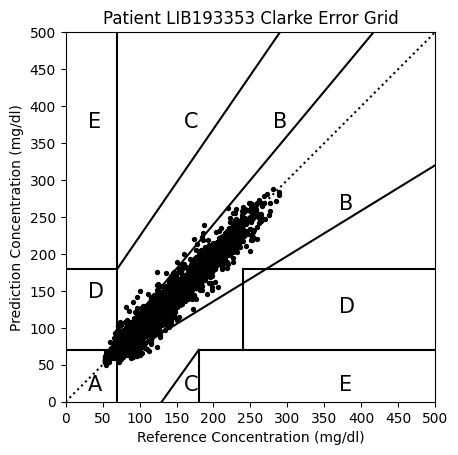

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('LIB193353', hor=2, kind=4, x_test=x_test, y_test=y_test, hidden_units=1024)

### Best Patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)

y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_train = x[:int(0.7*len(x))]
y_train = y[:int(0.7*len(y))]
x_val = x[int(0.7*len(x)):int(0.8*len(x))]
y_val = y[int(0.7*len(x)):int(0.8*len(x))]
x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

# TRAINING

hl = 8 # 2h
hor = 4
patient_id = 'lib193939'


print("########################################################################")
print(f"History lenght: {hl}, Horizon: {hor}")
hist = train(x_train, y_train, history_length= hl, horizon= hor, hidden_units = 1024,
      batch_size = 32, max_epochs = 1000, early_stopping_patience=50, extra_info_name =f'personalized{patient_id}withTuning-')
print("########################################################################")
print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
########################################################################
History lenght: 8, Horizon: 4
INFO: Training without validation
Epoch 1/1000
566/566 [==============================] - 141s 246ms/step - loss: 23.7191 - RMSE: 23.7129
Epoch 2/1000
566/566 [==============================] - 143s 253ms/step - loss: 16.8124 - RMSE: 16.8125
Epoch 3/1000
566/566 [==============================] - 141s 249ms/step - loss: 16.5354 - RMSE: 16.5359
Epoch 4/1000
566/566 [==============================] - 140s 248ms/step - loss: 16.4386 - RMSE: 16.4390
Epoch 5/1000
566/566 [==============================] - 141s 249ms/step - loss: 16.3492 - RMSE: 16.3507
Epoch 6/1000
566/566 [==============================] - 143s 253ms/step - loss: 16.2975 - RMSE: 16.2965
Epoch 7/1000
566/566 [==============================] - 140s 247ms/step - loss: 16.2708 - RMSE: 16.2704
Epoch 8/1000
566/566 [==============================] - 141s 250ms/step - loss: 16.2689 -

KeyboardInterrupt: ignored

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient lib193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedlib193939withTuning-LSTM-hl8-hor4.pkl
162/162 [==============================] - 10s 55ms/step - loss: 17.5761 - RMSE: 17.5897
RMSE: 17.589670181274414
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 10s 56ms/step
########################################################################

Number of values outside the grid: [0]


([17.576053619384766, 17.589670181274414],
 {'A': 78.00115986854823,
  'B': 18.538565629228685,
  'C': 0.0,
  'D': 3.460274502223081,
  'E': 0.0})

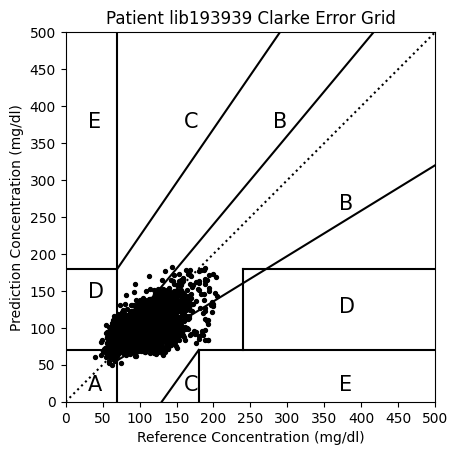

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

show_results('lib193939', hor=4, kind=4, x_test=x_test, y_test=y_test, hidden_units=1024)

# Personalized Real World Models

## Amount of data

In [ ]:
week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 10  # 1 window = 10 samples
windows_per_week = int(week / window_size)

%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_train = x[int(0.8*len(x) - (windows_per_week*3)):int(0.8*len(x))]
y_train = y[int(0.8*len(x) - (windows_per_week*3)):int(0.8*len(x))]
x_val  = x[:int(0.8*len(x) - (windows_per_week*3))]
y_val  = y[:int(0.8*len(x) - (windows_per_week*3))]

windows_to_time(x_train, precision="days")

/content/gdrive/MyDrive/TFG/GeneralisticModel
History length: 8
Number of Windows: 201


2.09375

## LSTM

### Tuning

#### Worst patient LIB193319

##### 30 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 10  # 1 window = 10 samples
windows_per_week = int(week / window_size)

max_weeks = 3

test_scores = []
for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    print(f"Length train: {x_train.shape[0]}")
    print(f"Length val: {x_val.shape[0]}")

    #print("########################################################################")
    #print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    #hist = train(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
    #             early_stopping_patience=epochs,
    #             extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    #print("########################################################################")
    #print()

    #np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)

    #print("########################################################################")
    #print("########################################################################")
    #print("########################################################################")
    #print()

    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_real_world', test_scores)


/content/gdrive/MyDrive/TFG/GeneralisticModel
Length train: 67
Length val: 1735
Weights: output/best-personalizedLIB193319-realWorld1Weeks-epochs500-LSTM-hl8-hor2.pkl
55/55 [==============================] - 1s 5ms/step - loss: 90.9103 - RMSE: 89.8551
RMSE: 89.85511016845703
Length train: 134
Length val: 1735
Weights: output/best-personalizedLIB193319-realWorld2Weeks-epochs500-LSTM-hl8-hor2.pkl
55/55 [==============================] - 1s 6ms/step - loss: 59.1897 - RMSE: 58.6751
RMSE: 58.675148010253906
Length train: 201
Length val: 1735
Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs500-LSTM-hl8-hor2.pkl
55/55 [==============================] - 1s 6ms/step - loss: 48.9652 - RMSE: 48.7927
RMSE: 48.792667388916016
Length train: 67
Length val: 1735
Weights: output/best-personalizedLIB193319-realWorld1Weeks-epochs750-LSTM-hl8-hor2.pkl
55/55 [==============================] - 1s 5ms/step - loss: 63.6785 - RMSE: 62.9933
RMSE: 62.993343353271484
Length train: 134
Length val:

In [ ]:
x_val.shape

(1180, 8)

In [ ]:
print(y_val.shape)

(1180, 1)


##### 60 min

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 12  # 1 window = 12 samples
windows_per_week = int(week / window_size)

max_weeks = 3

for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    print(f"Length train: {x_train.shape[0]}")
    print(f"Length validation: {x_val.shape[0]}")

    print("########################################################################")
    print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    hist = train(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
                 early_stopping_patience=epochs,
                 extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    print("########################################################################")
    print()

    np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)

    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print()

    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_60_real_world', test_scores)

#### Best patient 30 min LIB193353

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 10  # 1 window = 10 samples
windows_per_week = int(week / window_size)

max_weeks = 3

for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    #print(f"Length train: {x_train.shape[0]}")
    #print(f"Length val: {x_val.shape[0]}")
    #print("########################################################################")
    #print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    #hist = train(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
    #             early_stopping_patience=epochs,
    #             extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    #print("########################################################################")
    #print()

    #np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)



    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")

  print("########################################################################")
  print("########################################################################")
  print("########################################################################")
  print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Weights: output/best-personalizedLIB193353-realWorld1Weeks-epochs500-LSTM-hl8-hor2.pkl
641/641 [==============================] - 5s 6ms/step - loss: 25.9915 - RMSE: 25.9975
RMSE: 25.997480392456055
Weights: output/best-personalizedLIB193353-realWorld2Weeks-epochs500-LSTM-hl8-hor2.pkl
641/641 [==============================] - 4s 6ms/step - loss: 22.1435 - RMSE: 22.1540
RMSE: 22.153966903686523


Weights: output/best-personalizedLIB193353-realWorld3Weeks-epochs500-LSTM-hl8-hor2.pkl
641/641 [==============================] - 5s 6ms/step - loss: 22.8698 - RMSE: 22.8758
RMSE: 22.875757217407227
########################################################################
########################################################################
########################################################################

Weights: output/best-personalizedLIB193353-realWorld1Weeks-epochs750-LSTM-hl8-hor2.pkl
641/641 [==============================] - 4s 5ms/step - loss: 29.3654 - RMSE: 29.3674
RMSE: 29.367395401000977
Weights: output/best-personalizedLIB193353-realWorld2Weeks-epochs750-LSTM-hl8-hor2.pkl
641/641 [==============================] - 4s 6ms/step - loss: 22.6502 - RMSE: 22.6575
RMSE: 22.657533645629883
Weights: output/best-personalizedLIB193353-realWorld3Weeks-epochs750-LSTM-hl8-hor2.pkl
641/641 [==============================] - 4s 5ms/step - loss: 22.8418 - RMSE: 22.8459
RMSE: 22.

#### Best Patient 60 min LIB193939

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 4
patient_id = 'LIB193939'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 12  # 1 window = 12 samples
windows_per_week = int(week / window_size)

max_weeks = 3

for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*n_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*n_weeks))]

    #print(f"Length train: {x_train.shape[0]}")

    #print("########################################################################")
    #print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    #hist = train(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
    #             early_stopping_patience=epochs,
    #             extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    #print("########################################################################")
    #print()

    #np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)



    model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")

  print("########################################################################")
  print("########################################################################")
  print("########################################################################")
  print()

/content/gdrive/MyDrive/TFG/GeneralisticModel
Weights: output/best-personalizedLIB193939-realWorld1Weeks-epochs500-LSTM-hl8-hor4.pkl
645/645 [==============================] - 6s 7ms/step - loss: 23.0819 - RMSE: 23.0795
RMSE: 23.07953643798828
Weights: output/best-personalizedLIB193939-realWorld2Weeks-epochs500-LSTM-hl8-hor4.pkl
644/644 [==============================] - 5s 6ms/step - loss: 23.1495 - RMSE: 23.1536
RMSE: 23.153564453125
Weights: output/best-personalizedLIB193939-realWorld3Weeks-epochs500-LSTM-hl8-hor4.pkl


642/642 [==============================] - 6s 5ms/step - loss: 18.2720 - RMSE: 18.2741
RMSE: 18.274078369140625
########################################################################
########################################################################
########################################################################

Weights: output/best-personalizedLIB193939-realWorld1Weeks-epochs750-LSTM-hl8-hor4.pkl
645/645 [==============================] - 4s 5ms/step - loss: 23.0313 - RMSE: 23.0290
RMSE: 23.02903175354004
Weights: output/best-personalizedLIB193939-realWorld2Weeks-epochs750-LSTM-hl8-hor4.pkl
644/644 [==============================] - 4s 5ms/step - loss: 19.8458 - RMSE: 19.8473
RMSE: 19.847314834594727
Weights: output/best-personalizedLIB193939-realWorld3Weeks-epochs750-LSTM-hl8-hor4.pkl
642/642 [==============================] - 4s 5ms/step - loss: 18.8372 - RMSE: 18.8387
RMSE: 18.8387451171875
########################################################################
#

### Results

#### Tuning

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
import numpy as np
epochs = [500, 750, 1000]
n_weeks = [1, 2, 3]

p30_w = {"Patient":"LIB193319", "Horizon": "30min PH",
 "Results":np.load(f'output/tuning_results_LIB193319_real_world.npy')[:,1]}

p60_w = {"Patient":"LIB193319", "Horizon": "60min PH",
 "Results":[104.89509583,  77.54618835,  74.01187897,
        111.71759033,  84.33631897,  77.71219635,  97.5351181 ,
         77.93972778,  73.62683868]}

p30_b = {"Patient":"LIB193353", "Horizon": "30min PH",
 "Results":[26.00, 22.15, 25.88,29.37, 22.66, 22.85, 28.56, 24.05, 23.93]}

p60_b = {"Patient":"LIB193939", "Horizon": "60min PH",
 "Results":[23.08, 23.15, 18.27, 23.03, 19.85, 18.84, 23.03, 23.55, 19.16]}


# Index of minimum value for p30_w['Results']
min_index_p30_w = np.argmin(p30_w['Results'])
print("Minimum value in p30_w['Results'] is at index:", min_index_p30_w)

# Index of minimum value for p60_w['Results']
min_index_p60_w = np.argmin(p60_w['Results'])
print("Minimum value in p60_w['Results'] is at index:", min_index_p60_w)

# Index of minimum value for p30_b['Results']
min_index_p30_b = np.argmin(p30_b['Results'])
print("Minimum value in p30_b['Results'] is at index:", min_index_p30_b)

# Index of minimum value for p60_b['Results']
min_index_p60_b = np.argmin(p60_b['Results'])
print("Minimum value in p60_b['Results'] is at index:", min_index_p60_b)


/content/gdrive/MyDrive/TFG/GeneralisticModel
Minimum value in p30_w['Results'] is at index: 8
Minimum value in p60_w['Results'] is at index: 8
Minimum value in p30_b['Results'] is at index: 1
Minimum value in p60_b['Results'] is at index: 2


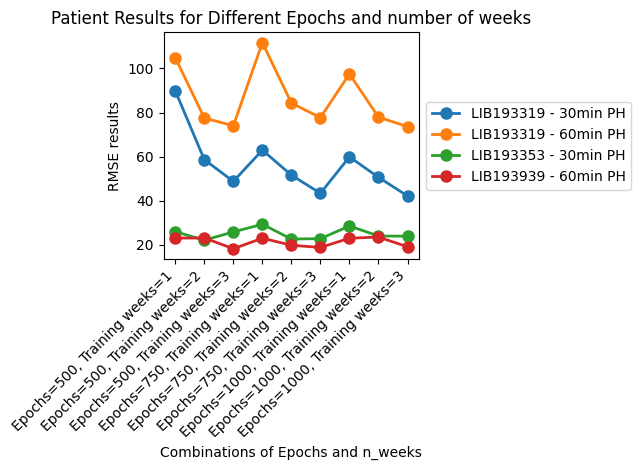

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots()

# Plot each patient's results with their combinations
for i, patient_data in enumerate([p30_w, p60_w, p30_b, p60_b]):
    patient_label = f"{patient_data['Patient']} - {patient_data['Horizon']}"
    ax.plot([f"Epochs={epoch}, Training weeks={week}" for epoch in epochs for week in n_weeks],
            patient_data["Results"],
            label=patient_label,
            marker='o', markersize=8, linewidth=2)

# Set labels and title
ax.set_xlabel("Combinations of Epochs and n_weeks")
ax.set_ylabel("RMSE results")
ax.set_title("Patient Results for Different Epochs and number of weeks")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()


#### Testing

In [ ]:
n_weeks = 3
epochs = 1000

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
x_test = x[int(0.8*len(x)):]
y_test = y[int(0.8*len(x)):]

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'



model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

test_score = model.evaluate(x_test, y_test)
print(f"RMSE: {test_score[1]}")


Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-LSTM-hl8-hor2.pkl
16/16 [==============================] - 1s 9ms/step - loss: 38.9654 - RMSE: 39.8766
RMSE: 39.87664794921875


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
x_test = x[int(0.8*len(x)):]
y_test = y[int(0.8*len(x)):]

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'



model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

test_score = model.evaluate(x_test, y_test)
print(f"RMSE: {test_score[1]}")

Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-LSTM-hl8-hor4.pkl
15/15 [==============================] - 1s 6ms/step - loss: 62.4183 - RMSE: 61.9924
RMSE: 61.9924430847168


In [ ]:
##%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
x_test = x[int(0.8*len(x)):]
y_test = y[int(0.8*len(x)):]

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'



model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

test_score = model.evaluate(x_test, y_test)
print(f"RMSE: {test_score[1]}")

Weights: output/best-personalizedLIB193353-realWorld3Weeks-epochs1000-LSTM-hl8-hor2.pkl
78/78 [==============================] - 1s 5ms/step - loss: 17.8307 - RMSE: 17.8634
RMSE: 17.863351821899414


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
x_test = x[int(0.8*len(x)):]
y_test = y[int(0.8*len(x)):]

hl = 8 # 2h
hor = 4
patient_id = 'LIB193939'



model = prepare_model_LSTM(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-LSTM-hl{hl}-hor{hor}.pkl')

test_score = model.evaluate(x_test, y_test)
print(f"RMSE: {test_score[1]}")

Weights: output/best-personalizedLIB193939-realWorld3Weeks-epochs1000-LSTM-hl8-hor4.pkl
162/162 [==============================] - 2s 5ms/step - loss: 19.7573 - RMSE: 19.7717
RMSE: 19.771678924560547


SEPARATOR

# Personalized Linear Real World models

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193319'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 10  # 1 window = 10 samples
windows_per_week = int(week / window_size)

max_weeks = 3

test_scores = []
for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    print(f"Length train: {x_train.shape[0]}")

    print("########################################################################")
    print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
                 early_stopping_patience=epochs,
                 extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    print("########################################################################")
    print()

    np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)

    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print()

    model = prepare_model_linear(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-Linear-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_30_real_world_linear', test_scores)


/content/gdrive/MyDrive/TFG/GeneralisticModel
Length train: 201
########################################################################
Weeks: 3, Epochs: 1000
Epoch 1/1000
7/7 [==============================] - 1s 19ms/step - loss: 111.6386 - RMSE: 114.0910
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 111.9255 - RMSE: 109.3676
Epoch 3/1000
7/7 [==============================] - 0s 3ms/step - loss: 110.4956 - RMSE: 113.4759
Epoch 4/1000
7/7 [==============================] - 0s 3ms/step - loss: 111.0208 - RMSE: 109.5104
Epoch 5/1000
7/7 [==============================] - 0s 19ms/step - loss: 110.3818 - RMSE: 107.9165
Epoch 6/1000
7/7 [==============================] - 0s 14ms/step - loss: 108.9863 - RMSE: 104.9957
Epoch 7/1000
7/7 [==============================] - 0s 3ms/step - loss: 108.0157 - RMSE: 112.6802
Epoch 8/1000
7/7 [==============================] - 0s 2ms/step - loss: 109.1788 - RMSE: 107.0244
Epoch 9/1000
7/7 [==============================] - 

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 4
patient_id = 'LIB193319'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 12  # 1 window = 12 samples
windows_per_week = int(week / window_size)

max_weeks = 3

test_scores = []
for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    print(f"Length train: {x_train.shape[0]}")

    print("########################################################################")
    print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
                 early_stopping_patience=epochs,
                 extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    print("########################################################################")
    print()


    print("########################################################################")
    print("########################################################################")
    print("########################################################################")
    print()

    model = prepare_model_linear(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-Linear-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_60_real_world_linear', test_scores)

Se han truncado las últimas 5000 líneas del flujo de salida.
2/2 [==============================] - 0s 6ms/step - loss: 51.0189 - RMSE: 49.8847
Epoch 518/1000
2/2 [==============================] - 0s 8ms/step - loss: 51.0171 - RMSE: 52.1428
Epoch 519/1000
2/2 [==============================] - 0s 6ms/step - loss: 51.3637 - RMSE: 50.6497
Epoch 520/1000
2/2 [==============================] - 0s 10ms/step - loss: 51.0858 - RMSE: 52.1231
Epoch 521/1000
2/2 [==============================] - 0s 6ms/step - loss: 51.3297 - RMSE: 52.0806
Epoch 522/1000
2/2 [==============================] - 0s 5ms/step - loss: 51.5173 - RMSE: 51.8521
Epoch 523/1000
2/2 [==============================] - 0s 6ms/step - loss: 51.4540 - RMSE: 51.9445
Epoch 524/1000
2/2 [==============================] - 0s 6ms/step - loss: 51.4614 - RMSE: 50.9987
Epoch 525/1000
2/2 [==============================] - 0s 6ms/step - loss: 51.4782 - RMSE: 51.1151
Epoch 526/1000
2/2 [==============================] - 0s 6ms/step - los

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 2
patient_id = 'LIB193353'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 10  # 1 window = 10 samples
windows_per_week = int(week / window_size)

max_weeks = 3

test_scores = []
for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*max_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*max_weeks))]

    print(f"Length train: {x_train.shape[0]}")

    print("########################################################################")
    print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
                 early_stopping_patience=epochs,
                 extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    print("########################################################################")
    print()

    np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)



    model = prepare_model_linear(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-Linear-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_30_real_world_linear', test_scores)



/content/gdrive/MyDrive/TFG/GeneralisticModel
Length train: 67
########################################################################
Weeks: 1, Epochs: 500
Epoch 1/500
3/3 [==============================] - 1s 88ms/step - loss: 90.9408 - RMSE: 86.9272
Epoch 2/500
3/3 [==============================] - 0s 4ms/step - loss: 87.9834 - RMSE: 87.0473
Epoch 3/500
3/3 [==============================] - 0s 100ms/step - loss: 84.9986 - RMSE: 84.4027
Epoch 4/500
3/3 [==============================] - 0s 112ms/step - loss: 81.7439 - RMSE: 72.2439
Epoch 5/500
3/3 [==============================] - 0s 5ms/step - loss: 79.1668 - RMSE: 82.9443
Epoch 6/500
3/3 [==============================] - 0s 5ms/step - loss: 76.3874 - RMSE: 77.7042
Epoch 7/500
3/3 [==============================] - 0s 97ms/step - loss: 72.7862 - RMSE: 57.1217
Epoch 8/500
3/3 [==============================] - 0s 3ms/step - loss: 70.8308 - RMSE: 68.1961
Epoch 9/500
3/3 [==============================] - 0s 4ms/step - loss: 68.12

Se han truncado las últimas 5000 líneas del flujo de salida.
3/3 [==============================] - 0s 4ms/step - loss: 23.4284 - RMSE: 24.7881
Epoch 512/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.5378 - RMSE: 21.7854
Epoch 513/1000
3/3 [==============================] - 0s 5ms/step - loss: 23.2360 - RMSE: 21.2266
Epoch 514/1000
3/3 [==============================] - 0s 4ms/step - loss: 22.6467 - RMSE: 30.9696
Epoch 515/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.5099 - RMSE: 22.9806
Epoch 516/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.3972 - RMSE: 19.9714
Epoch 517/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.2004 - RMSE: 22.0881
Epoch 518/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.4668 - RMSE: 24.1164
Epoch 519/1000
3/3 [==============================] - 0s 4ms/step - loss: 23.1256 - RMSE: 19.2036
Epoch 520/1000
3/3 [==============================] - 0s 4ms/step - loss

In [ ]:
30%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

/content/gdrive/MyDrive/TFG/GeneralisticModel


In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel

hl = 8 # 2h
hor = 4
patient_id = 'LIB193939'

week = 672       # 1 week = 168 hours. 4 measurements per hour --> 672 samples
window_size = 12  # 1 window = 12 samples
windows_per_week = int(week / window_size)

max_weeks = 3

test_scores = []
for epochs in [500, 750, 1000]:
  for n_weeks in range(1,4):

    x_train = x[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    y_train = y[int(0.8*len(x) - (windows_per_week*n_weeks)):int(0.8*len(x))]
    x_val  = x[:int(0.8*len(x) - (windows_per_week*n_weeks))]
    y_val  = y[:int(0.8*len(x) - (windows_per_week*n_weeks))]

    print(f"Length train: {x_train.shape[0]}")

    print("########################################################################")
    print(f"Weeks: {n_weeks}, Epochs: {epochs}")
    hist = train_baseline(x_train, y_train, history_length= hl, horizon= hor, batch_size = 32, max_epochs = epochs,
                 early_stopping_patience=epochs,
                 extra_info_name =f'personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-')
    print("########################################################################")
    print()

    np.save(f'output/training_history_{patient_id}_real_world_{n_weeks}Weeks-epochs{epochs}', hist.history)



    model = prepare_model_linear(history_length=hl,
                               weights= f'output/best-personalized{patient_id}-realWorld{n_weeks}Weeks-epochs{epochs}-Linear-hl{hl}-hor{hor}.pkl')

    test_score = model.evaluate(x_val, y_val)
    print(f"RMSE: {test_score[1]}")
    test_scores.append(test_score)

np.save(f'output/tuning_results_{patient_id}_60_real_world_linear', test_scores)


Se han truncado las últimas 5000 líneas del flujo de salida.
6/6 [==============================] - 0s 51ms/step - loss: 25.0598 - RMSE: 23.7286
Epoch 264/750
6/6 [==============================] - 0s 56ms/step - loss: 24.9678 - RMSE: 23.1594
Epoch 265/750
6/6 [==============================] - 0s 3ms/step - loss: 25.0589 - RMSE: 23.6566
Epoch 266/750
6/6 [==============================] - 0s 3ms/step - loss: 25.0514 - RMSE: 25.2446
Epoch 267/750
6/6 [==============================] - 0s 3ms/step - loss: 24.9116 - RMSE: 23.9310
Epoch 268/750
6/6 [==============================] - 0s 3ms/step - loss: 24.8926 - RMSE: 23.9762
Epoch 269/750
6/6 [==============================] - 0s 3ms/step - loss: 24.8628 - RMSE: 24.5321
Epoch 270/750
6/6 [==============================] - 0s 2ms/step - loss: 24.4356 - RMSE: 25.8772
Epoch 271/750
6/6 [==============================] - 0s 3ms/step - loss: 24.8130 - RMSE: 25.6920
Epoch 272/750
6/6 [==============================] - 0s 3ms/step - loss: 24.91

6/6 [==============================] - 2s 52ms/step - loss: 43.6613 - RMSE: 44.4457
Epoch 2/1000
6/6 [==============================] - 0s 59ms/step - loss: 39.6668 - RMSE: 38.9014
Epoch 3/1000
6/6 [==============================] - 0s 50ms/step - loss: 35.7847 - RMSE: 34.6577
Epoch 4/1000
6/6 [==============================] - 0s 52ms/step - loss: 32.1068 - RMSE: 32.1948
Epoch 5/1000
6/6 [==============================] - 0s 52ms/step - loss: 28.6636 - RMSE: 28.7571
Epoch 6/1000
6/6 [==============================] - 0s 49ms/step - loss: 25.5933 - RMSE: 26.7337
Epoch 7/1000
6/6 [==============================] - 0s 57ms/step - loss: 22.8902 - RMSE: 22.3633
Epoch 8/1000
6/6 [==============================] - 0s 48ms/step - loss: 20.9318 - RMSE: 20.3116
Epoch 9/1000
6/6 [==============================] - 0s 4ms/step - loss: 19.2849 - RMSE: 20.4977
Epoch 10/1000
6/6 [==============================] - 0s 53ms/step - loss: 18.5535 - RMSE: 18.3589
Epoch 11/1000
6/6 [========================

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
import numpy as np
epochs = [500, 750, 1000]
n_weeks = [1, 2, 3]

p30_w = {"Patient":"LIB193319", "Horizon": "30min PH",
 "Results":np.load(f'output/tuning_results_LIB193319_30_real_world_linear.npy')[:,1]}

p60_w = {"Patient":"LIB193319", "Horizon": "60min PH",
 "Results":np.load(f'output/tuning_results_LIB193319_60_real_world_linear.npy')[:,1]}

p30_b = {"Patient":"LIB193353", "Horizon": "30min PH",
 "Results":np.load(f'output/tuning_results_LIB193353_30_real_world_linear.npy')[:,1]}

p60_b = {"Patient":"LIB193939", "Horizon": "60min PH",
 "Results":np.load(f'output/tuning_results_LIB193939_60_real_world_linear.npy')[:,1]}

/content/gdrive/MyDrive/TFG/GeneralisticModel


## Results tuning

In [ ]:
import numpy as np

# Assuming that p30_w['Results'], p60_w['Results'], p30_b['Results'], and p60_w['Results'] are NumPy arrays

# Index of minimum value for p30_w['Results']
min_index_p30_w = np.argmin(p30_w['Results'])
print("Minimum value in p30_w['Results'] is at index:", min_index_p30_w)

# Index of minimum value for p60_w['Results']
min_index_p60_w = np.argmin(p60_w['Results'])
print("Minimum value in p60_w['Results'] is at index:", min_index_p60_w)

# Index of minimum value for p30_b['Results']
min_index_p30_b = np.argmin(p30_b['Results'])
print("Minimum value in p30_b['Results'] is at index:", min_index_p30_b)

# Index of minimum value for p60_b['Results']
min_index_p60_b = np.argmin(p60_b['Results'])
print("Minimum value in p60_b['Results'] is at index:", min_index_p60_b)


Minimum value in p30_w['Results'] is at index: 8
Minimum value in p60_w['Results'] is at index: 6
Minimum value in p30_b['Results'] is at index: 8
Minimum value in p60_b['Results'] is at index: 6


In [ ]:
p30_w

{'Patient': 'LIB193319',
 'Horizon': '30min PH',
 'Results': array([37.42602158, 40.33367157, 36.29984283, 37.67967606, 36.01348114,
        34.33145523, 38.31427383, 36.77186203, 33.40270615])}

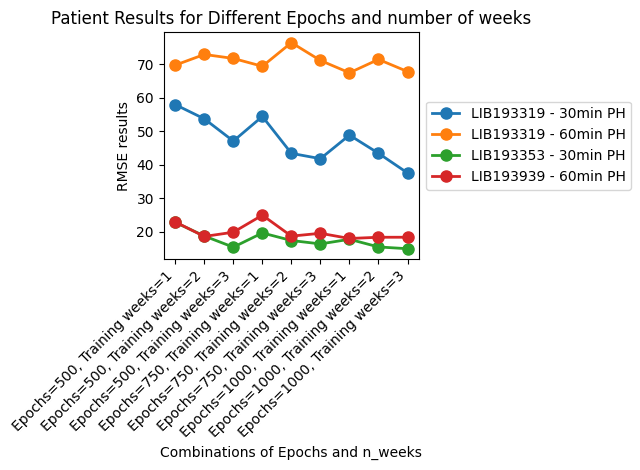

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax = plt.subplots()

# Plot each patient's results with their combinations
for i, patient_data in enumerate([p30_w, p60_w, p30_b, p60_b]):
    patient_label = f"{patient_data['Patient']} - {patient_data['Horizon']}"
    ax.plot([f"Epochs={epoch}, Training weeks={week}" for epoch in epochs for week in n_weeks],
            patient_data["Results"],
            label=patient_label,
            marker='o', markersize=8, linewidth=2)

# Set labels and title
ax.set_xlabel("Combinations of Epochs and n_weeks")
ax.set_ylabel("RMSE results")
ax.set_title("Patient Results for Different Epochs and number of weeks")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Add a legend
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.tight_layout()
plt.show()


# Results

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-LSTM-hl8-hor2.pkl
16/16 [==============================] - 1s 7ms/step - loss: 38.9654 - RMSE: 39.8766
RMSE: 39.87664794921875
########################################################################

########################################################################
Predicting BG values...


16/16 [==============================] - 1s 5ms/step
########################################################################

Number of values outside the grid: [0]


([38.96538543701172, 39.87664794921875],
 {'A': 72.10743801652893,
  'B': 24.173553719008265,
  'C': 1.0330578512396695,
  'D': 2.6859504132231407,
  'E': 0.0})

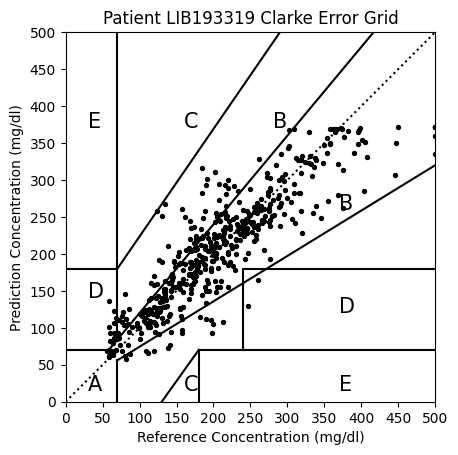

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

show_results('LIB193319', hor=2, kind=4, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

Patient LIB193319
########################################################################
484 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-Linear-hl8-hor2.pkl
16/16 [==============================] - 0s 2ms/step - loss: 38.7322 - RMSE: 39.3841
RMSE: 39.384056091308594
########################################################################

########################################################################
Predicting BG values...
16/16 [==============================] - 0s 1ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [526.2216] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [1]


([38.732154846191406, 39.384056091308594],
 {'A': 74.3801652892562,
  'B': 23.553719008264462,
  'C': 0.0,
  'D': 2.066115702479339,
  'E': 0.0})

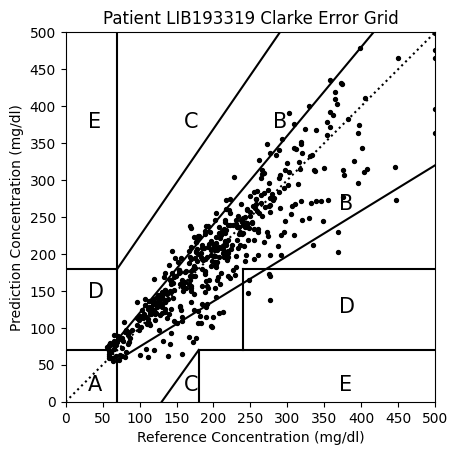

In [ ]:
show_results('LIB193319', hor=2, kind=5, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-LSTM-hl8-hor4.pkl
15/15 [==============================] - 1s 9ms/step - loss: 62.4183 - RMSE: 61.9924
RMSE: 61.9924430847168
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 1s 8ms/step
########################################################################

Number of values outside the grid: [0]


([62.41828155517578, 61.9924430847168],
 {'A': 44.46854663774403,
  'B': 47.071583514099785,
  'C': 1.735357917570499,
  'D': 6.507592190889371,
  'E': 0.21691973969631237})

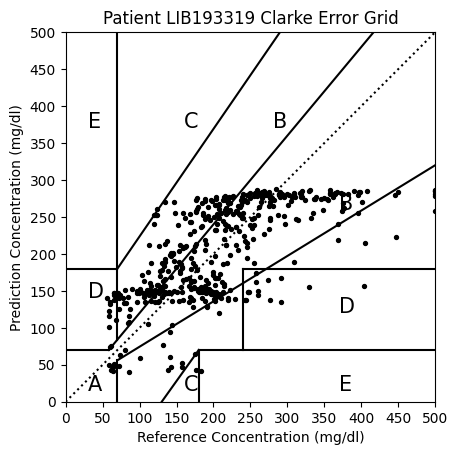

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193319.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193319.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

show_results('LIB193319', hor=4, kind=4, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

Patient LIB193319
########################################################################
461 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193319-realWorld3Weeks-epochs1000-Linear-hl8-hor4.pkl
15/15 [==============================] - 0s 2ms/step - loss: 61.4257 - RMSE: 60.6603
RMSE: 60.660301208496094
########################################################################

########################################################################
Predicting BG values...
15/15 [==============================] - 0s 1ms/step
########################################################################

Input Warning: the maximum reference value [500.] or the maximum prediction value [504.4169] exceeds the normal physiological range of glucose (<400 mg/dl).
Number of values outside the grid: [1]


([61.42573165893555, 60.660301208496094],
 {'A': 47.722342733188725,
  'B': 43.817787418655094,
  'C': 1.3015184381778742,
  'D': 6.724511930585683,
  'E': 0.43383947939262474})

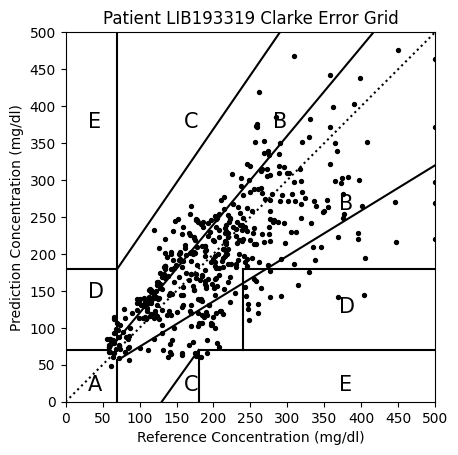

In [ ]:
show_results('LIB193319', hor=4, kind=5, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193353-realWorld3Weeks-epochs1000-LSTM-hl8-hor2.pkl
78/78 [==============================] - 2s 8ms/step - loss: 17.8307 - RMSE: 17.8634
RMSE: 17.863351821899414
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 1s 6ms/step
########################################################################

Number of values outside the grid: [0]


([17.830659866333008, 17.863351821899414],
 {'A': 80.85192697768763,
  'B': 13.184584178498987,
  'C': 0.0,
  'D': 5.963488843813387,
  'E': 0.0})

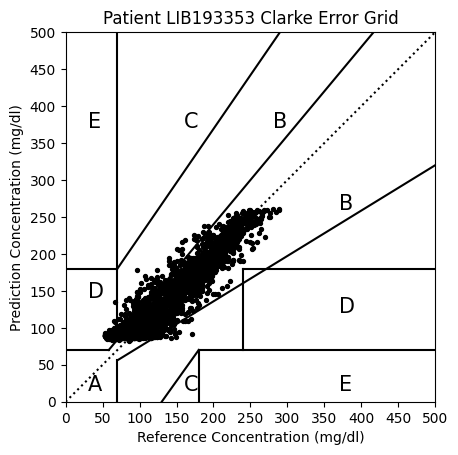

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_2_LIB193353.npy'
file_y = 'windows/y_train_windows_history_8_horizon_2_LIB193353.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

show_results('LIB193353', hor=2, kind=4, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

Patient LIB193353
########################################################################
2465 windows
########################################################################
History lenght: 8, Horizon: 2
Weights: output/best-personalizedLIB193353-realWorld3Weeks-epochs1000-Linear-hl8-hor2.pkl
78/78 [==============================] - 0s 2ms/step - loss: 17.1989 - RMSE: 17.3865
RMSE: 17.38652229309082
########################################################################

########################################################################
Predicting BG values...
78/78 [==============================] - 0s 2ms/step
########################################################################

Number of values outside the grid: [0]


([17.19894790649414, 17.38652229309082],
 {'A': 87.05882352941177,
  'B': 12.170385395537526,
  'C': 0.0,
  'D': 0.7707910750507099,
  'E': 0.0})

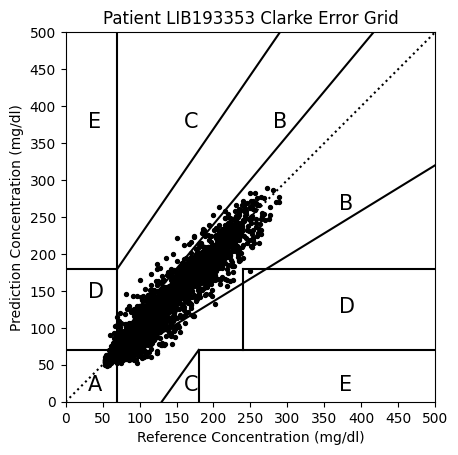

In [ ]:
show_results('LIB193353', hor=2, kind=5, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

/content/gdrive/MyDrive/TFG/GeneralisticModel
Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193939-realWorld3Weeks-epochs1000-LSTM-hl8-hor4.pkl
162/162 [==============================] - 2s 7ms/step - loss: 19.7573 - RMSE: 19.7717
RMSE: 19.771678924560547
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 2s 7ms/step
########################################################################

Number of values outside the grid: [0]


([19.757259368896484, 19.771678924560547],
 {'A': 74.67620336361878,
  'B': 22.40479412333269,
  'C': 0.0,
  'D': 2.919002513048521,
  'E': 0.0})

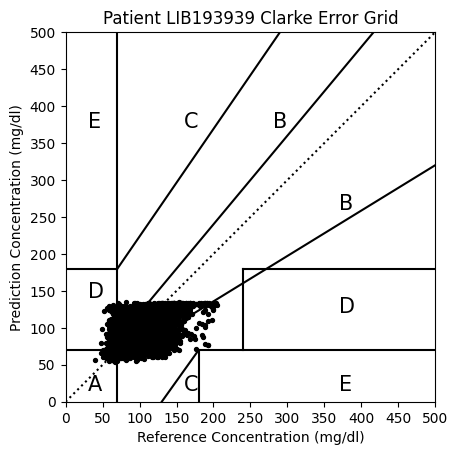

In [ ]:
%cd /content/gdrive/MyDrive/TFG/GeneralisticModel
file_x = 'windows/x_train_windows_history_8_horizon_4_LIB193939.npy'
file_y = 'windows/y_train_windows_history_8_horizon_4_LIB193939.npy'
x = np.load(file_x)
y = np.load(file_y)
y = y[:, -1]
y = y.reshape((y.shape[0], 1))

x_test  = x[int(0.8*len(x)):]
y_test  = y[int(0.8*len(x)):]

show_results('LIB193939', hor=4, kind=4, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)

Patient LIB193939
########################################################################
5173 windows
########################################################################
History lenght: 8, Horizon: 4
Weights: output/best-personalizedLIB193939-realWorld3Weeks-epochs1000-Linear-hl8-hor4.pkl
162/162 [==============================] - 1s 2ms/step - loss: 21.1101 - RMSE: 21.1298
RMSE: 21.129783630371094
########################################################################

########################################################################
Predicting BG values...
162/162 [==============================] - 0s 2ms/step
########################################################################

Number of values outside the grid: [0]


([21.11012077331543, 21.129783630371094],
 {'A': 71.96984341774599,
  'B': 25.63309491590953,
  'C': 0.0,
  'D': 2.397061666344481,
  'E': 0.0})

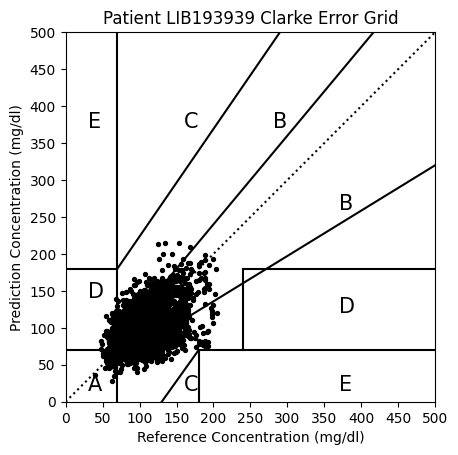

In [ ]:
show_results('LIB193939', hor=4, kind=5, x_test=x_test, y_test=y_test, epochs=1000, n_weeks=3)